# Бриф

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

Нужно выявить определяющие успешность игры закономерности, это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании: очистить и подготовить данные, найти общий объем продаж, посмотреть на динамику развития популярности тех или иных платформ. Затем, основываясь на сделаных выводах, необходимо выделить срез данных для прогнозирования рынка на следующий год. Также, нужно составить портрет геймера по регионам (США, Япония и Европа) - посмотреть, какие платформы и жанры пользуются большей популярностью у пользователей из разных стран.
Наконец, нужно проверить следующие нулевые гипотезы:
* средние пользовательские рейтинги платформ Xbox One и PC одинаковые
* средние пользовательские рейтинги жанров Action и Sports одинаковые

### Первый взгляд на данные

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
game_data = pd.read_csv(R'C:\Users\polin\Downloads\games.csv')
display(game_data, game_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


None

Первое, что бросается в глаза - заглавные буквы в названиях столбцов, а также в самих данных. С ними нужно разобраться в первую очередь:

In [3]:
game_data.columns = game_data.columns.str.lower()
lower = ['name', 'platform', 'genre']
for column in lower:
    game_data[column] = game_data[column].str.lower()

Теперь посмотрим, сколько пропусков в столбце с годом выпуска - эти данные наиболее проблематично восстановить или же чем-то заполнить:

In [4]:
game_data['year_of_release'].isna().value_counts()

False    16446
True       269
Name: year_of_release, dtype: int64

Потеря данных составит всего порядка 1,6% - можно удалять без зазрения совести:

In [5]:
game_data = game_data.copy().dropna(subset=['year_of_release']).reset_index(drop=True)
game_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006.0,sports,41.36,28.96,3.77,8.45,76.0,8,E
1,super mario bros.,nes,1985.0,platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,mario kart wii,wii,2008.0,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii sports resort,wii,2009.0,sports,15.61,10.93,3.28,2.95,80.0,8,E
4,pokemon red/pokemon blue,gb,1996.0,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16441,samurai warriors: sanada maru,ps3,2016.0,action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16442,lma manager 2007,x360,2006.0,sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16443,haitaka no psychedelica,psv,2016.0,adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16444,spirits & spells,gba,2003.0,platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Переведем данные о годе выхода игры в формат datetime:

In [6]:
game_data['year_of_release'] = game_data['year_of_release'].astype('int')
game_data['year_of_release'] = pd.to_datetime(game_data['year_of_release'].copy(), format='%Y')

Поскольку пропущенные значения в столбцах с оценками критиков и пользователей значительно усложняют дальнейшую работу, то заменим их на 0:

In [7]:
game_data.loc[(game_data.user_score == 'tbd'), 'user_score'] = 0
game_data[['critic_score', 'user_score']] = game_data[['critic_score', 'user_score']].copy().fillna(0)
game_data['user_score'] = game_data['user_score'].copy().astype('float')

Аналогично поступим и с пропусками в рейтинге:

In [8]:
game_data['rating'].value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

In [9]:
game_data['rating'] = game_data['rating'].copy().fillna('none')

In [10]:
has_rating = game_data.query('rating != "none"')
display(has_rating, has_rating.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9768 entries, 0 to 16437
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             9768 non-null   object        
 1   platform         9768 non-null   object        
 2   year_of_release  9768 non-null   datetime64[ns]
 3   genre            9768 non-null   object        
 4   na_sales         9768 non-null   float64       
 5   eu_sales         9768 non-null   float64       
 6   jp_sales         9768 non-null   float64       
 7   other_sales      9768 non-null   float64       
 8   critic_score     9768 non-null   float64       
 9   user_score       9768 non-null   float64       
 10  rating           9768 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 915.8+ KB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006-01-01,sports,41.36,28.96,3.77,8.45,76.0,8.0,E
2,mario kart wii,wii,2008-01-01,racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,wii sports resort,wii,2009-01-01,sports,15.61,10.93,3.28,2.95,80.0,8.0,E
6,new super mario bros.,ds,2006-01-01,platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,wii play,wii,2006-01-01,misc,13.96,9.18,2.93,2.84,58.0,6.6,E
...,...,...,...,...,...,...,...,...,...,...,...
16428,bust-a-move 3000,gc,2003-01-01,puzzle,0.01,0.00,0.00,0.00,53.0,0.0,E
16429,mega brain boost,ds,2008-01-01,puzzle,0.01,0.00,0.00,0.00,48.0,0.0,E
16433,storm: frontline nation,pc,2011-01-01,strategy,0.00,0.01,0.00,0.00,60.0,7.2,E10+
16435,plushees,ds,2008-01-01,simulation,0.01,0.00,0.00,0.00,0.0,0.0,E


None

Создадим столбец с суммарной выручкой каждой игры:

In [11]:
game_data['year'] = game_data['year_of_release'].dt.year
game_data['general_sales'] = game_data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
display(game_data, game_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16446 entries, 0 to 16445
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             16444 non-null  object        
 1   platform         16446 non-null  object        
 2   year_of_release  16446 non-null  datetime64[ns]
 3   genre            16444 non-null  object        
 4   na_sales         16446 non-null  float64       
 5   eu_sales         16446 non-null  float64       
 6   jp_sales         16446 non-null  float64       
 7   other_sales      16446 non-null  float64       
 8   critic_score     16446 non-null  float64       
 9   user_score       16446 non-null  float64       
 10  rating           16446 non-null  object        
 11  year             16446 non-null  int64         
 12  general_sales    16446 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(4)
memory usage: 1.6+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year,general_sales
0,wii sports,wii,2006-01-01,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,2006,82.54
1,super mario bros.,nes,1985-01-01,platform,29.08,3.58,6.81,0.77,0.0,0.0,none,1985,40.24
2,mario kart wii,wii,2008-01-01,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,2008,35.52
3,wii sports resort,wii,2009-01-01,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,2009,32.77
4,pokemon red/pokemon blue,gb,1996-01-01,role-playing,11.27,8.89,10.22,1.00,0.0,0.0,none,1996,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16441,samurai warriors: sanada maru,ps3,2016-01-01,action,0.00,0.00,0.01,0.00,0.0,0.0,none,2016,0.01
16442,lma manager 2007,x360,2006-01-01,sports,0.00,0.01,0.00,0.00,0.0,0.0,none,2006,0.01
16443,haitaka no psychedelica,psv,2016-01-01,adventure,0.00,0.00,0.01,0.00,0.0,0.0,none,2016,0.01
16444,spirits & spells,gba,2003-01-01,platform,0.01,0.00,0.00,0.00,0.0,0.0,none,2003,0.01


None

### Анализ и исследование

#### Прибыльность различных платформ

Посмотрим, какие платформы приносили наибольшее количество денег за все годы:

<AxesSubplot:xlabel='platform'>

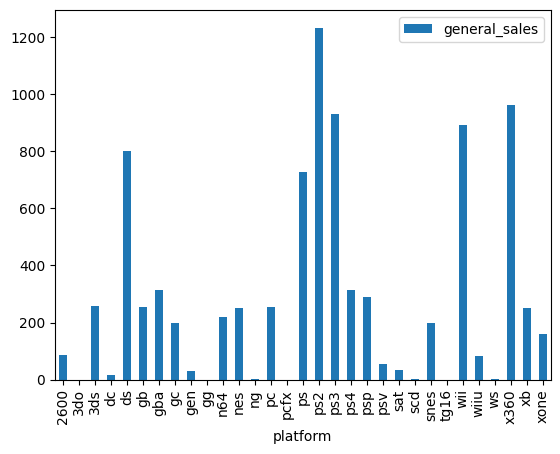

In [12]:
all_time_platform = pd.pivot_table(game_data, index = 'platform', values = 'general_sales', aggfunc = 'sum')
all_time_platform.plot(kind='bar', y='general_sales')

In [13]:
all_time_platform.sort_values(by='general_sales', ascending=False)

,general_sales
platform,
ps2,1233.56
x360,961.24
ps3,931.34
wii,891.18
ds,802.78
ps,727.58
ps4,314.14
gba,312.88
psp,289.53


Итак, можно заметить, что лидером является ps2, затем идут x360 и ps3, а после - wii, ds, ps. 

#### Количество игр по годам

Проведем аналогичное исследование и по количеству игр по годам:

<AxesSubplot:xlabel='year'>

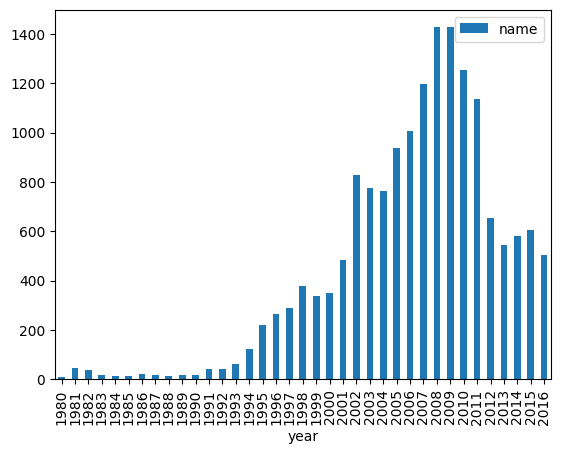

In [14]:
all_time_year = pd.pivot_table(game_data, index = 'year', values = 'name', aggfunc = 'count')
all_time_year.plot(kind='bar', y='name')

Пик игровой индустрии, судя по графику, пришелся на 2008-2009 годы, а наибольшее количество игр было выпущено примерно в период с 2005 по 2011 год.

#### Динамика жизни платформ

Посмотрим на общую картину жизни наиболее успешных (с точки зрения продаж игр) платформ в ретроспективе:

In [15]:
platform_year = game_data.query('platform == ("ps2", "x360", "ps3", "wii", "ds", "ps")')
platform = pd.pivot_table(platform_year, index = ['year', 'platform'], values = 'general_sales', aggfunc="sum")
platform.sort_values(by='general_sales', ascending=False).head(10)

,,general_sales
year,platform,
2004,ps2,211.81
2009,wii,206.97
2002,ps2,205.38
2003,ps2,184.31
2008,wii,171.32
2010,x360,170.03
1998,ps,169.49
2001,ps2,166.43
2005,ps2,160.66


<AxesSubplot:xlabel='year', ylabel='general_sales'>

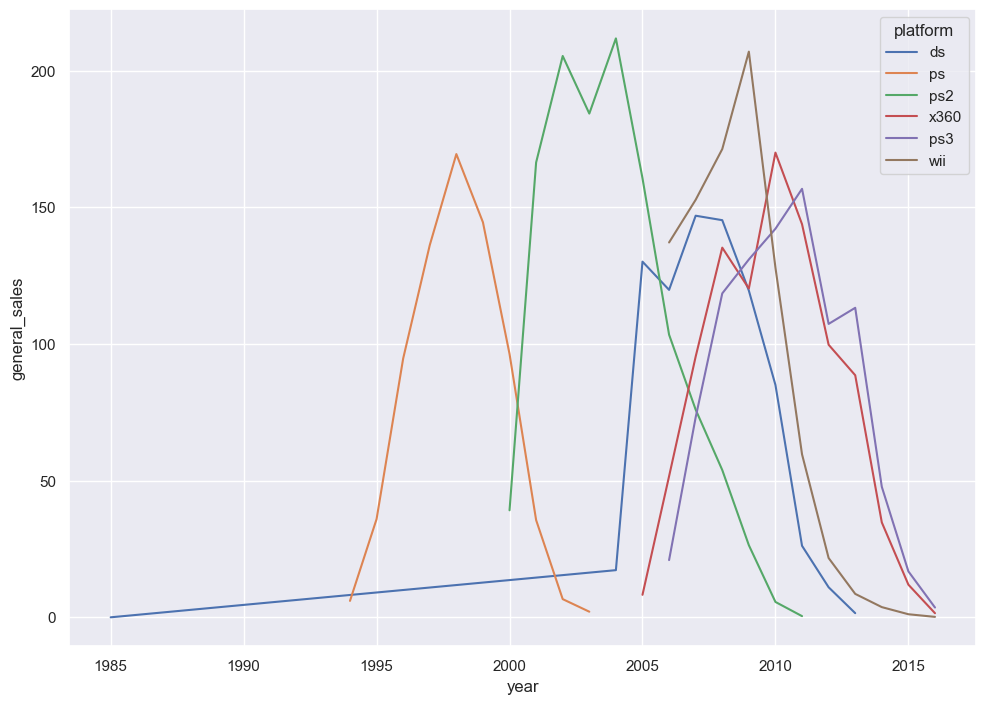

In [16]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=platform, x='year', y='general_sales', hue='platform')

Как можно заметить, средняя продолжительность активной жизни той или иной платформы - примерно пять лет, при этом пик ее популярности находится в центре этого промежутка времени. Наибольший всплеск активности платформ наблюдается в период примерно с 2007 по 2013, затем наступает резкий спад.

#### Вывод

* Лидером по количеству продаж за все время мониторинга является ps2, затем идут x360 и ps3, а после - wii, ds, ps
* Пик игровой индустрии, судя по графику, пришелся на 2008-2009 годы, а наибольшее количество игр было выпущено в период с 2005 по 2011 год
* Средняя продолжительность активной жизни той или иной платформы - примерно пять лет, при этом пик ее популярности находится в центре этого промежутка времени; наибольший всплеск активности платформ наблюдается в период с 2007 по 2013, затем наступает резкий спад

### Анализ актуального периода

Нам необходимо сделать прогноз для 2017 года - следовательно, имеет смысл взять отрезок времени в 2-3 года, т.е. с 2014 по текущий, 2016:

In [17]:
recent = game_data.query('year >= 2014')
recent['user_score'] = recent['user_score'].copy().astype('float')
recent

C:\Users\polin\AppData\Local\Temp\ipykernel_64132\2563063766.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent['user_score'] = recent['user_score'].copy().astype('float')


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year,general_sales
31,call of duty: black ops 3,ps4,2015-01-01,shooter,6.03,5.86,0.36,2.38,0.0,0.0,none,2015,14.63
42,grand theft auto v,ps4,2014-01-01,action,3.96,6.31,0.38,1.97,97.0,8.3,M,2014,12.62
47,pokemon omega ruby/pokemon alpha sapphire,3ds,2014-01-01,role-playing,4.35,3.49,3.10,0.74,0.0,0.0,none,2014,11.68
77,fifa 16,ps4,2015-01-01,sports,1.12,6.12,0.06,1.28,82.0,4.3,E,2015,8.58
87,star wars battlefront (2015),ps4,2015-01-01,shooter,2.99,3.49,0.22,1.28,0.0,0.0,none,2015,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16434,strawberry nauts,psv,2016-01-01,adventure,0.00,0.00,0.01,0.00,0.0,0.0,none,2016,0.01
16438,aiyoku no eustia,psv,2014-01-01,misc,0.00,0.00,0.01,0.00,0.0,0.0,none,2014,0.01
16441,samurai warriors: sanada maru,ps3,2016-01-01,action,0.00,0.00,0.01,0.00,0.0,0.0,none,2016,0.01
16443,haitaka no psychedelica,psv,2016-01-01,adventure,0.00,0.00,0.01,0.00,0.0,0.0,none,2016,0.01


,general_sales
platform,
ps4,288.15
xone,140.36
3ds,86.68
ps3,68.18
x360,48.22
wiiu,42.98
pc,27.05
psv,22.40
wii,5.07


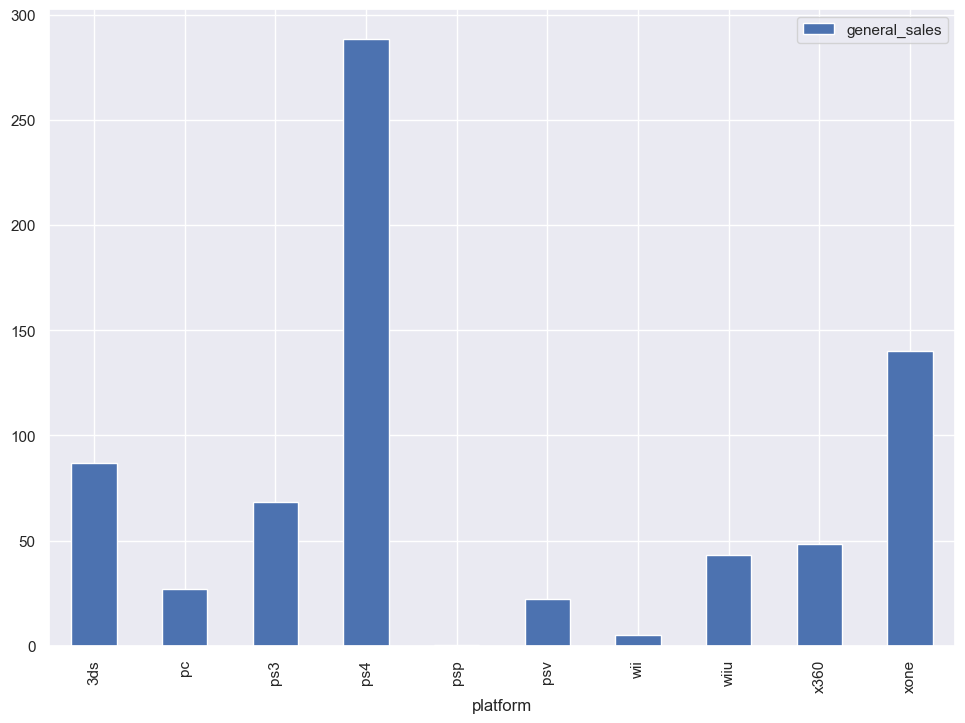

In [18]:
recent_sales = pd.pivot_table(recent, index = 'platform', values = 'general_sales', aggfunc = 'sum')
recent_sales.plot(kind='bar', y='general_sales')
recent_sales.sort_values(by='general_sales', ascending=False)

In [19]:
platform_recent = recent.query('platform == ("ps4", "xone", "3ds")')
platform_dynamics = pd.pivot_table(platform_recent, index = ['year', 'platform'], values = 'general_sales', aggfunc="sum")
platform_dynamics.sort_values(by='general_sales', ascending=False).head(10)

general_sales
year platform               
2015 ps4              118.90
2014 ps4              100.00
2016 ps4               69.25
2015 xone              60.14
2014 xone              54.07
     3ds               43.76
2015 3ds               27.78
2016 xone              26.15
     3ds               15.14

<AxesSubplot:xlabel='year', ylabel='general_sales'>

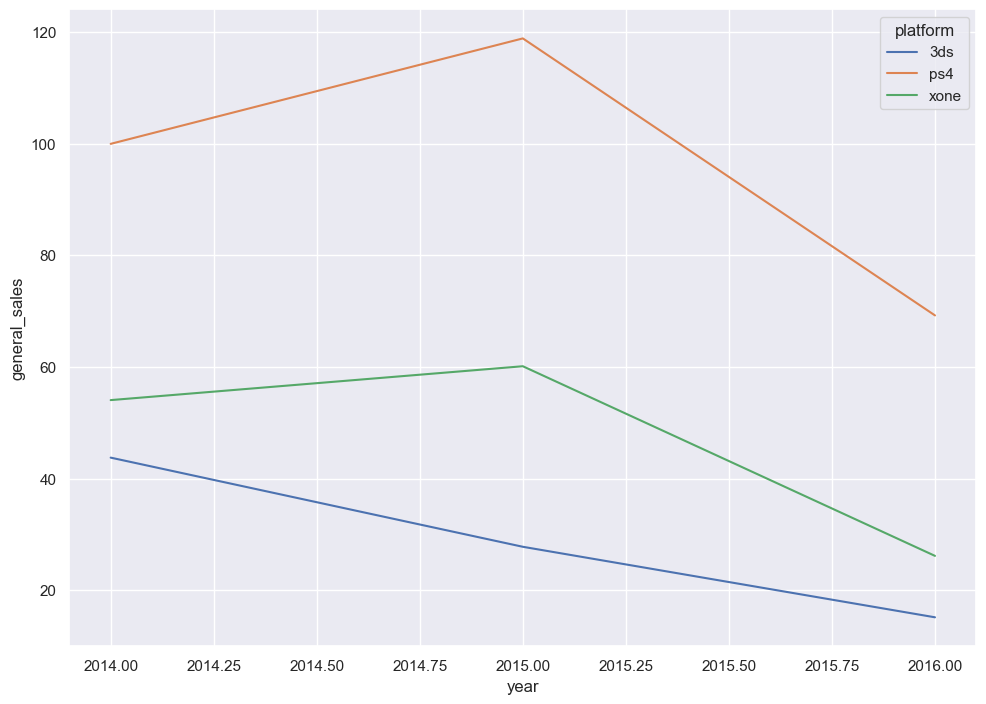

In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=platform_dynamics, x='year', y='general_sales', hue='platform')

Итак, у playstation4 и xone наблюдается пик, приходящийся на 2015 год, затем идет спад (у 3ds этот спад начинается с 2014 года). Наиболее популярной на данный период остается playstation4, а xone и 3ds переживают не лучшие времена.

<AxesSubplot:>

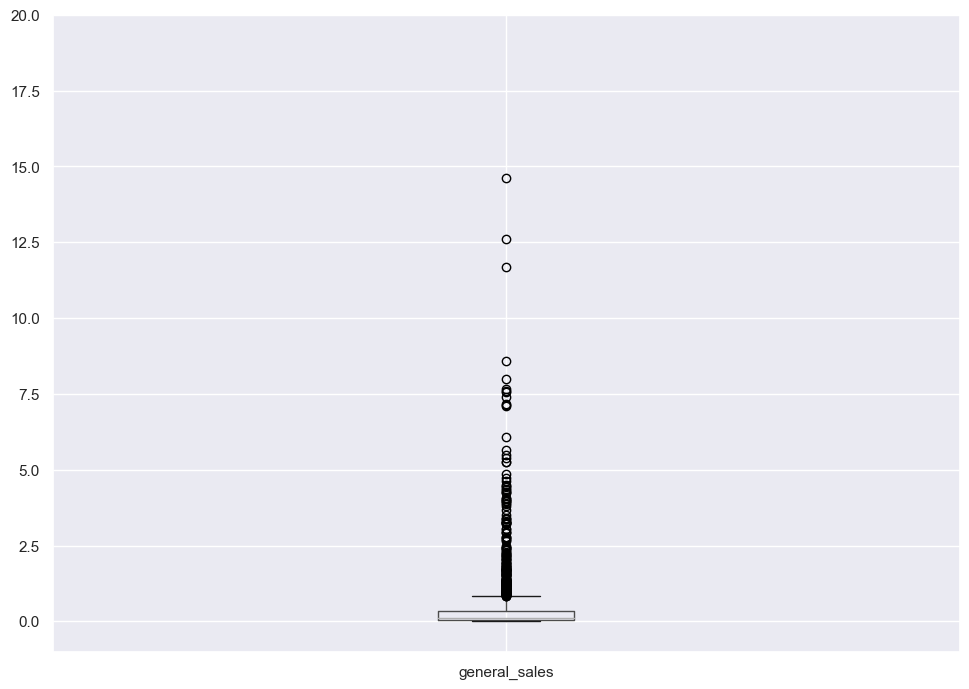

In [21]:
box = recent[['platform', 'general_sales']]
plt.ylim(-1, 20)
box.boxplot()

Можно увидеть, что основной массив продаж лежит в пределах до 5 млн. Также есть небольшие группы игр от 5 до 6 млн, от 7 до 8,5 млн и выбросы от 12 до 15 млн.

### Зависимость между отзывами и продажами

In [22]:
ps4 = recent.query('platform == "ps4"')
ps4_scatter = ps4[['platform', 'year', 'critic_score', 'user_score', 'general_sales']]
#ps4_scatter['critic_score'] = ps4_critic['critic_score'].copy()/10
ps4_scatter['user_score'] = ps4_scatter['user_score'].copy()*10
ps4_scatter

C:\Users\polin\AppData\Local\Temp\ipykernel_64132\3290248073.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps4_scatter['user_score'] = ps4_scatter['user_score'].copy()*10


,platform,year,critic_score,user_score,general_sales
31,ps4,2015,0.0,0.0,14.63
42,ps4,2014,97.0,83.0,12.62
77,ps4,2015,82.0,43.0,8.58
87,ps4,2015,0.0,0.0,7.98
92,ps4,2014,83.0,57.0,7.66
...,...,...,...,...,...
16232,ps4,2016,69.0,75.0,0.01
16235,ps4,2016,0.0,0.0,0.01
16257,ps4,2016,61.0,79.0,0.01
16261,ps4,2016,51.0,55.0,0.01


,year,critic_score,user_score,general_sales
year,1.000000,-0.079938,-0.047829,-0.214338
critic_score,-0.079938,1.000000,0.903670,0.211837
user_score,-0.047829,0.903670,1.000000,0.101448
general_sales,-0.214338,0.211837,0.101448,1.000000


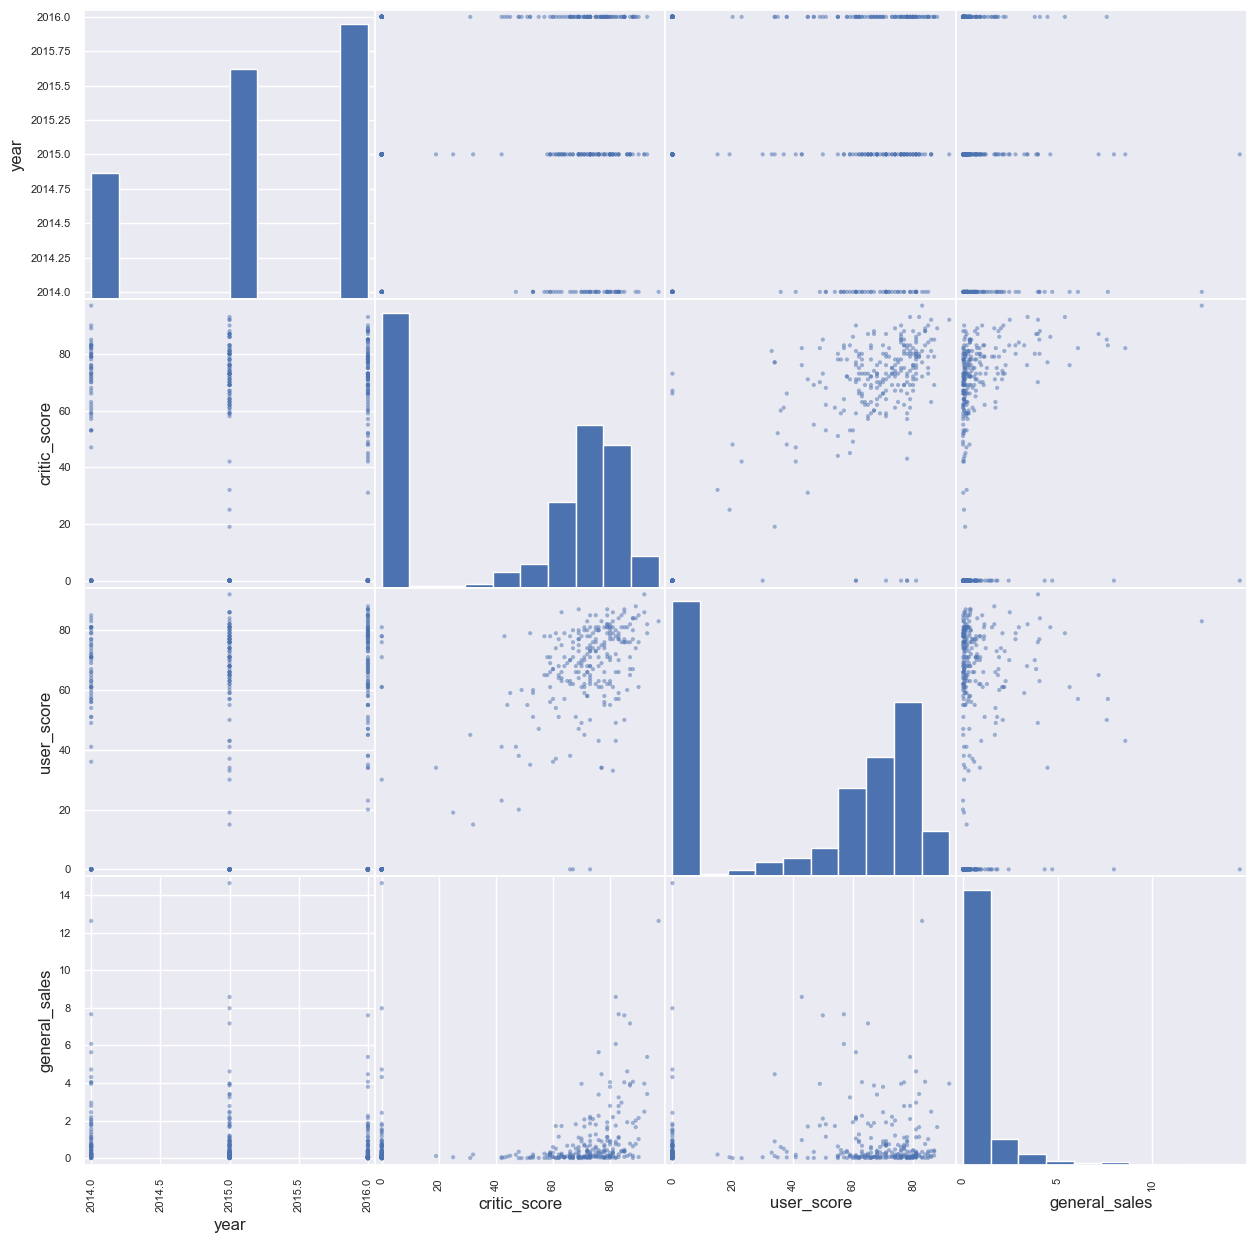

In [23]:
pd.plotting.scatter_matrix(ps4_scatter, figsize=(15, 15))
ps4_scatter.corr()

Мы видим, что в случае с playstation4 отзывы критиков влияют на продажи чуть больше, чем отзывы пользователей (корреляция 0,21 и 0,1 соответственно), также, можно заметить и отрицательный рост продаж на протяжении выбранного периода времени, и, соответственно, количества отзывов как критиков, так и пользователей. Интересна также и сильная взяимосвязь между оценками пользователей и критиков - вероятно, оценки у тех и других получают в общей сложности одни и те же игры.

In [24]:
xone = recent.query('platform == "xone"')
xone_scatter = xone[['platform', 'year', 'critic_score', 'user_score', 'general_sales']]
xone_scatter['user_score'] = xone_scatter['user_score'].copy()*10
xone_scatter

C:\Users\polin\AppData\Local\Temp\ipykernel_64132\3771048758.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xone_scatter['user_score'] = xone_scatter['user_score'].copy()*10


,platform,year,critic_score,user_score,general_sales
99,xone,2015,0.0,0.0,7.39
165,xone,2014,97.0,79.0,5.47
179,xone,2014,81.0,54.0,5.26
241,xone,2015,84.0,64.0,4.49
269,xone,2015,88.0,62.0,4.22
...,...,...,...,...,...
16361,xone,2016,63.0,82.0,0.01
16374,xone,2016,0.0,66.0,0.01
16376,xone,2016,0.0,0.0,0.01
16391,xone,2016,74.0,67.0,0.01


,year,critic_score,user_score,general_sales
year,1.000000,-0.010476,0.025870,-0.231327
critic_score,-0.010476,1.000000,0.793371,0.272518
user_score,0.025870,0.793371,1.000000,0.102074
general_sales,-0.231327,0.272518,0.102074,1.000000


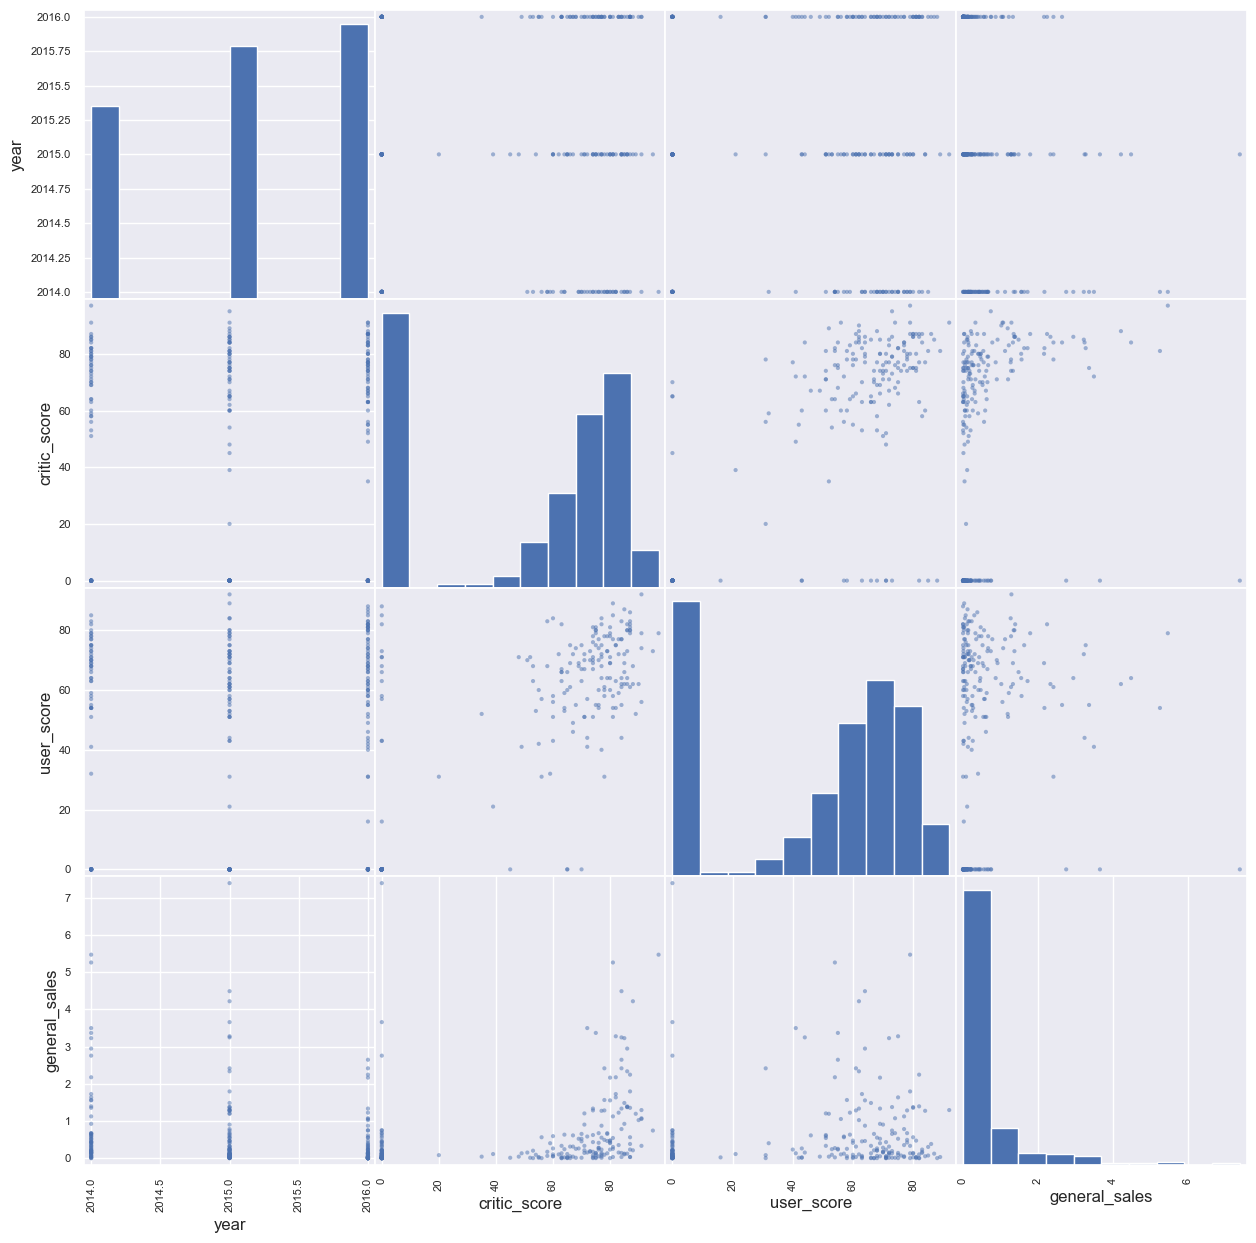

In [25]:
pd.plotting.scatter_matrix(xone_scatter, figsize=(15, 15))
xone_scatter.corr()

В целом, ситуация с Xbox One похожа на предыдущую, однако, тут корреляция между оценками критиков и продажами несколько больше (0,27 против 0,21) и меньше зависимость между отзывами критиков и пользователей (0,79 против 0,9).

In [26]:
ds3 = recent.query('platform == "3ds"')
ds3_scatter = ds3[['platform', 'year', 'critic_score', 'user_score', 'general_sales']]
ds3_scatter['user_score'] = ds3_scatter['user_score'].copy()*10
ds3_scatter

C:\Users\polin\AppData\Local\Temp\ipykernel_64132\744669165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds3_scatter['user_score'] = ds3_scatter['user_score'].copy()*10


,platform,year,critic_score,user_score,general_sales
47,3ds,2014,0.0,0.0,11.68
96,3ds,2014,0.0,0.0,7.55
108,3ds,2016,0.0,0.0,7.14
311,3ds,2014,86.0,87.0,3.89
404,3ds,2015,0.0,0.0,3.32
...,...,...,...,...,...
16330,3ds,2014,0.0,0.0,0.01
16339,3ds,2015,0.0,0.0,0.01
16341,3ds,2015,0.0,0.0,0.01
16399,3ds,2014,0.0,0.0,0.01


,year,critic_score,user_score,general_sales
year,1.000000,-0.034204,0.012365,-0.077659
critic_score,-0.034204,1.000000,0.887491,0.053255
user_score,0.012365,0.887491,1.000000,0.054922
general_sales,-0.077659,0.053255,0.054922,1.000000


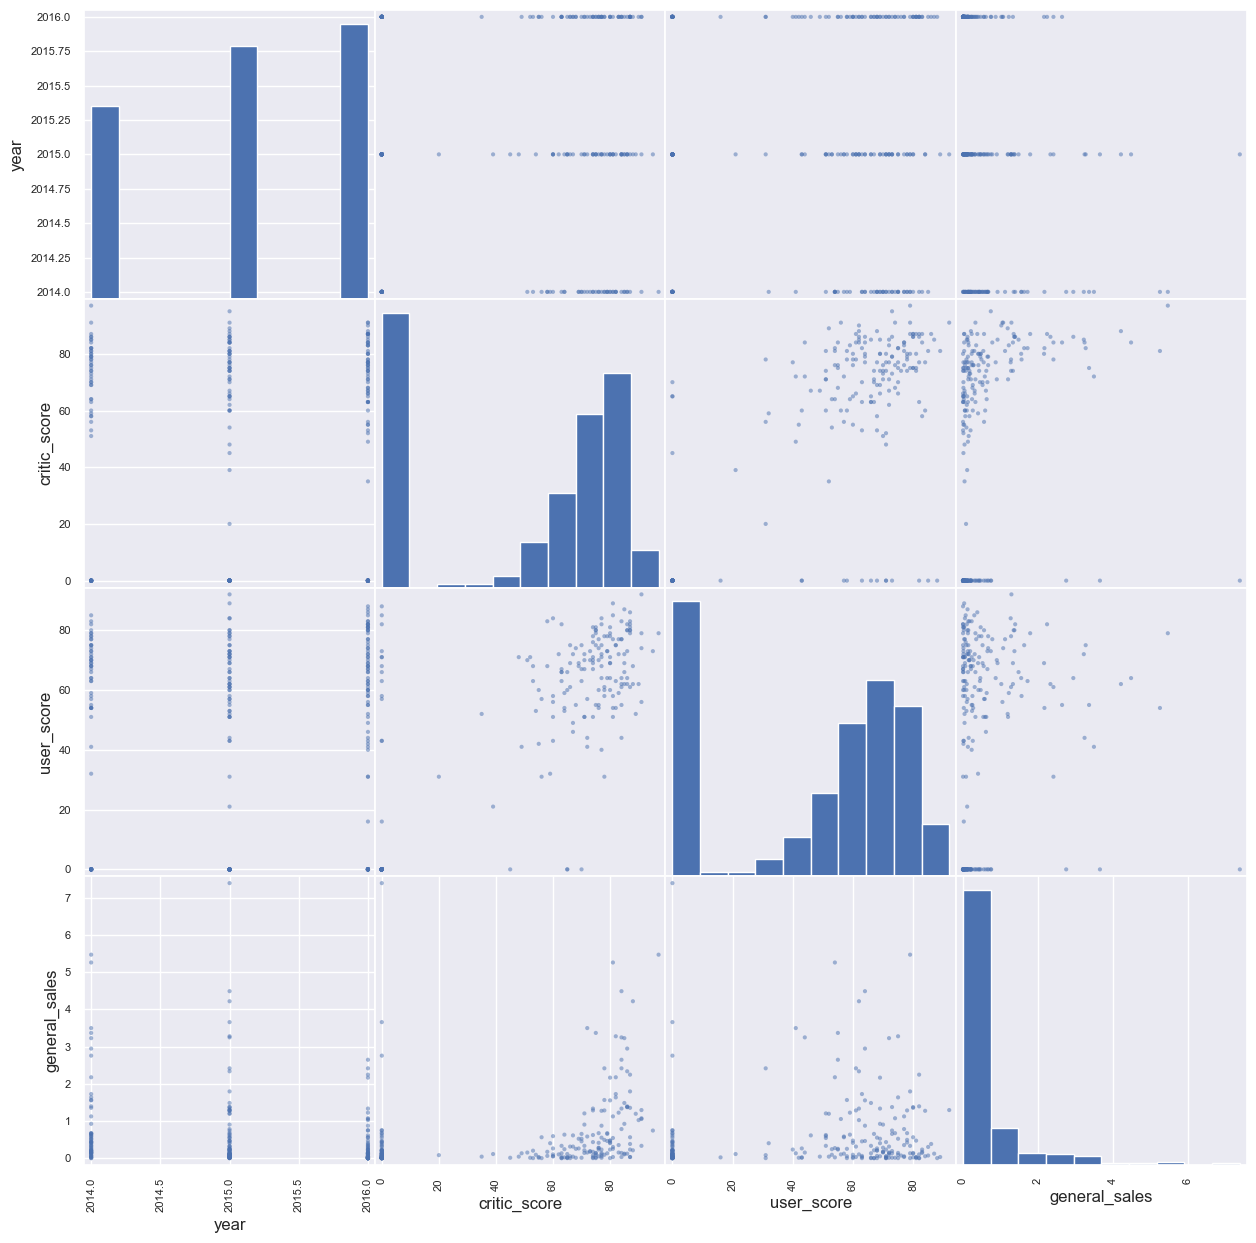

In [27]:
pd.plotting.scatter_matrix(xone_scatter, figsize=(15, 15))
ds3_scatter.corr()

Из всех платформ у Nintendo DS 3 наблюдается самая слабая корреляция между оценками и продажами (по 0,05 и для пользователей, и для критиков), но, также, и самая слабая отрицательная корреляция между годами и продажами, что может говорить о том, что продажи игр на этой платформе наиболее стабильны, и не испытывают столь сильного спада, как в двух остальных случаях.

#### Вывод

*  В случае с playstation4 отзывы критиков влияют на продажи чуть больше, чем отзывы пользователей (корреляция 0,21 и 0,1 соответственно), также, можно заметить и отрицательный рост продаж на протяжении выбранного периода времени, и, соответственно, количества отзывов как критиков, так и пользователей. Интересна также и сильная взяимосвязь между оценками пользователей и критиков - вероятно, оценки у тех и других получают в общей сложности одни и те же игры
* ситуация с Xbox One похожа на предыдущую, однако, тут корреляция между оценками критиков и продажами несколько больше (0,27 против 0,21) и меньше зависимость между отзывами критиков и пользователей (0,79 против 0,9)
* у Nintendo DS 3 наблюдается самая слабая корреляция между оценками и продажами (по 0,05 и для пользователей, и для критиков), но, также, и самая слабая отрицательная корреляция между годами и продажами, что может говорить о том, что продажи игр на этой платформе наиболее стабильны, и не испытывают столь сильного спада, как в двух остальных случаях

### Популярность игровых жанров

In [28]:
genres = recent[['genre', 'year', 'general_sales']]
genres

,genre,year,general_sales
31,shooter,2015,14.63
42,action,2014,12.62
47,role-playing,2014,11.68
77,sports,2015,8.58
87,shooter,2015,7.98
...,...,...,...
16434,adventure,2016,0.01
16438,misc,2014,0.01
16441,action,2016,0.01
16443,adventure,2016,0.01


In [29]:
general_sales = pd.pivot_table(genres, index = ['genre', 'year'], values = 'general_sales', aggfunc = 'median')
general_sales.sort_values(by='general_sales', ascending=False)

,,general_sales
genre,year,
shooter,2015,0.925
platform,2014,0.830
shooter,2014,0.660
sports,2014,0.460
shooter,2016,0.240
action,2014,0.205
simulation,2015,0.200
misc,2015,0.190
racing,2014,0.170


<AxesSubplot:xlabel='year', ylabel='general_sales'>

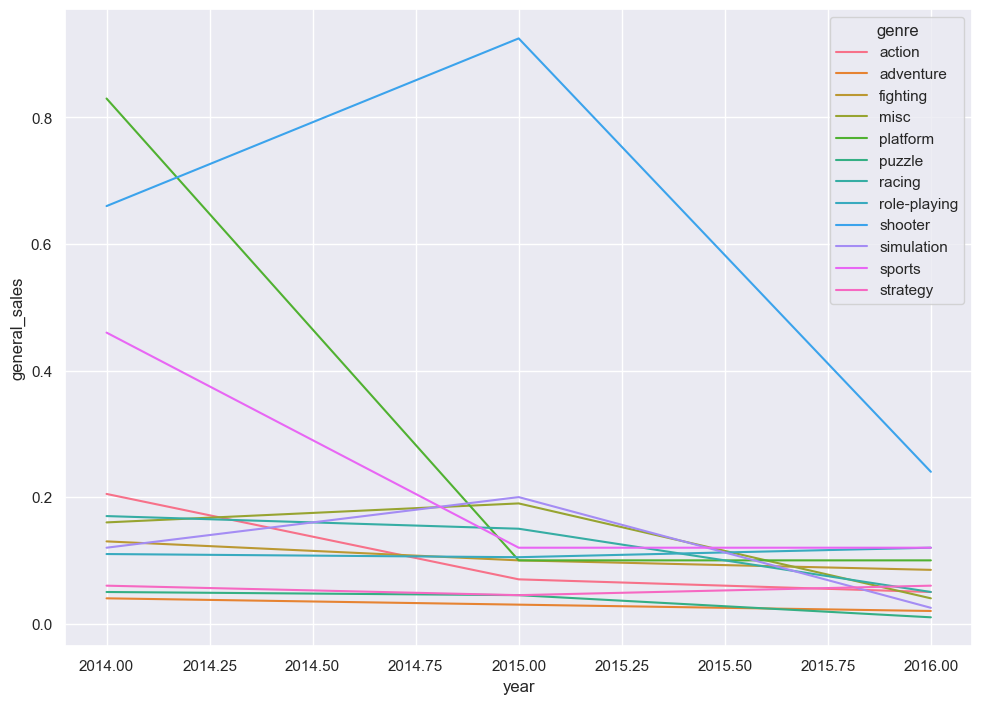

In [30]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=general_sales, x='year', y='general_sales', hue='genre')

#### Вывод

Среди жанров с высокими продажами находятся action, shooter, sports и role-playing - между ними и остальными жанрами наблюдается значительный разрыв прибыльности. Наименее популярны игры жанров puzzle, strategy и simulation.

### Региональные предпочтения

#### Популярные жанры 

In [31]:
reg_genre = recent[['year', 'genre', 'na_sales', 'eu_sales', 'jp_sales']]
reg_genre_sales = pd.pivot_table(reg_genre, index = ['genre', 'year'], values = ['na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'sum')
display(reg_genre_sales)

eu_sales  jp_sales  na_sales
genre        year                              
action       2014     39.86      6.53     38.85
             2015     24.14     15.98     24.39
             2016     10.68      7.07      9.29
adventure    2014      1.82      1.38      1.80
             2015      3.35      1.04      2.89
             2016      1.32      1.18      0.95
fighting     2014      2.97      4.83      6.89
             2015      2.38      0.79      3.70
             2016      1.34      0.75      1.84
misc         2014      8.60      2.42      9.47
             2015      3.60      2.15      4.82
             2016      0.66      1.04      0.76
platform     2014      3.60      1.27      3.01
             2015      1.81      1.31      2.49
             2016      1.39      0.11      1.29
puzzle       2014      0.39      0.41      0.59
             2015      0.12      0.52      0.06
             2016      0.01      0.00      0.00
racing       2014      7.61      1.47      5.92
             2015      4.75      0.28      2.09
             2016      1.77      0.01      0.73
role-playing 2014     10.96     17.75     13.65
             2015     12.93      6.80     13.93
             2016      4.28      6.61      5.89
shooter      2014     25.24      1.08     30.84
             2015     24.38      2.73     31.94
             2016     15.90      1.06     16.24
simulation   2014      3.56      0.38      1.27
             2015      2.47      1.60      1.20
             2016      1.27      0.33      0.16
sports       2014     17.91      1.61     19.82
             2015     15.81      0.73     18.77
             2016     12.01      0.92      7.54
strategy     2014      0.22      0.56      0.16
             2015      0.98      0.16      0.58
             2016      0.59      0.23      0.24

<AxesSubplot:xlabel='year', ylabel='na_sales'>

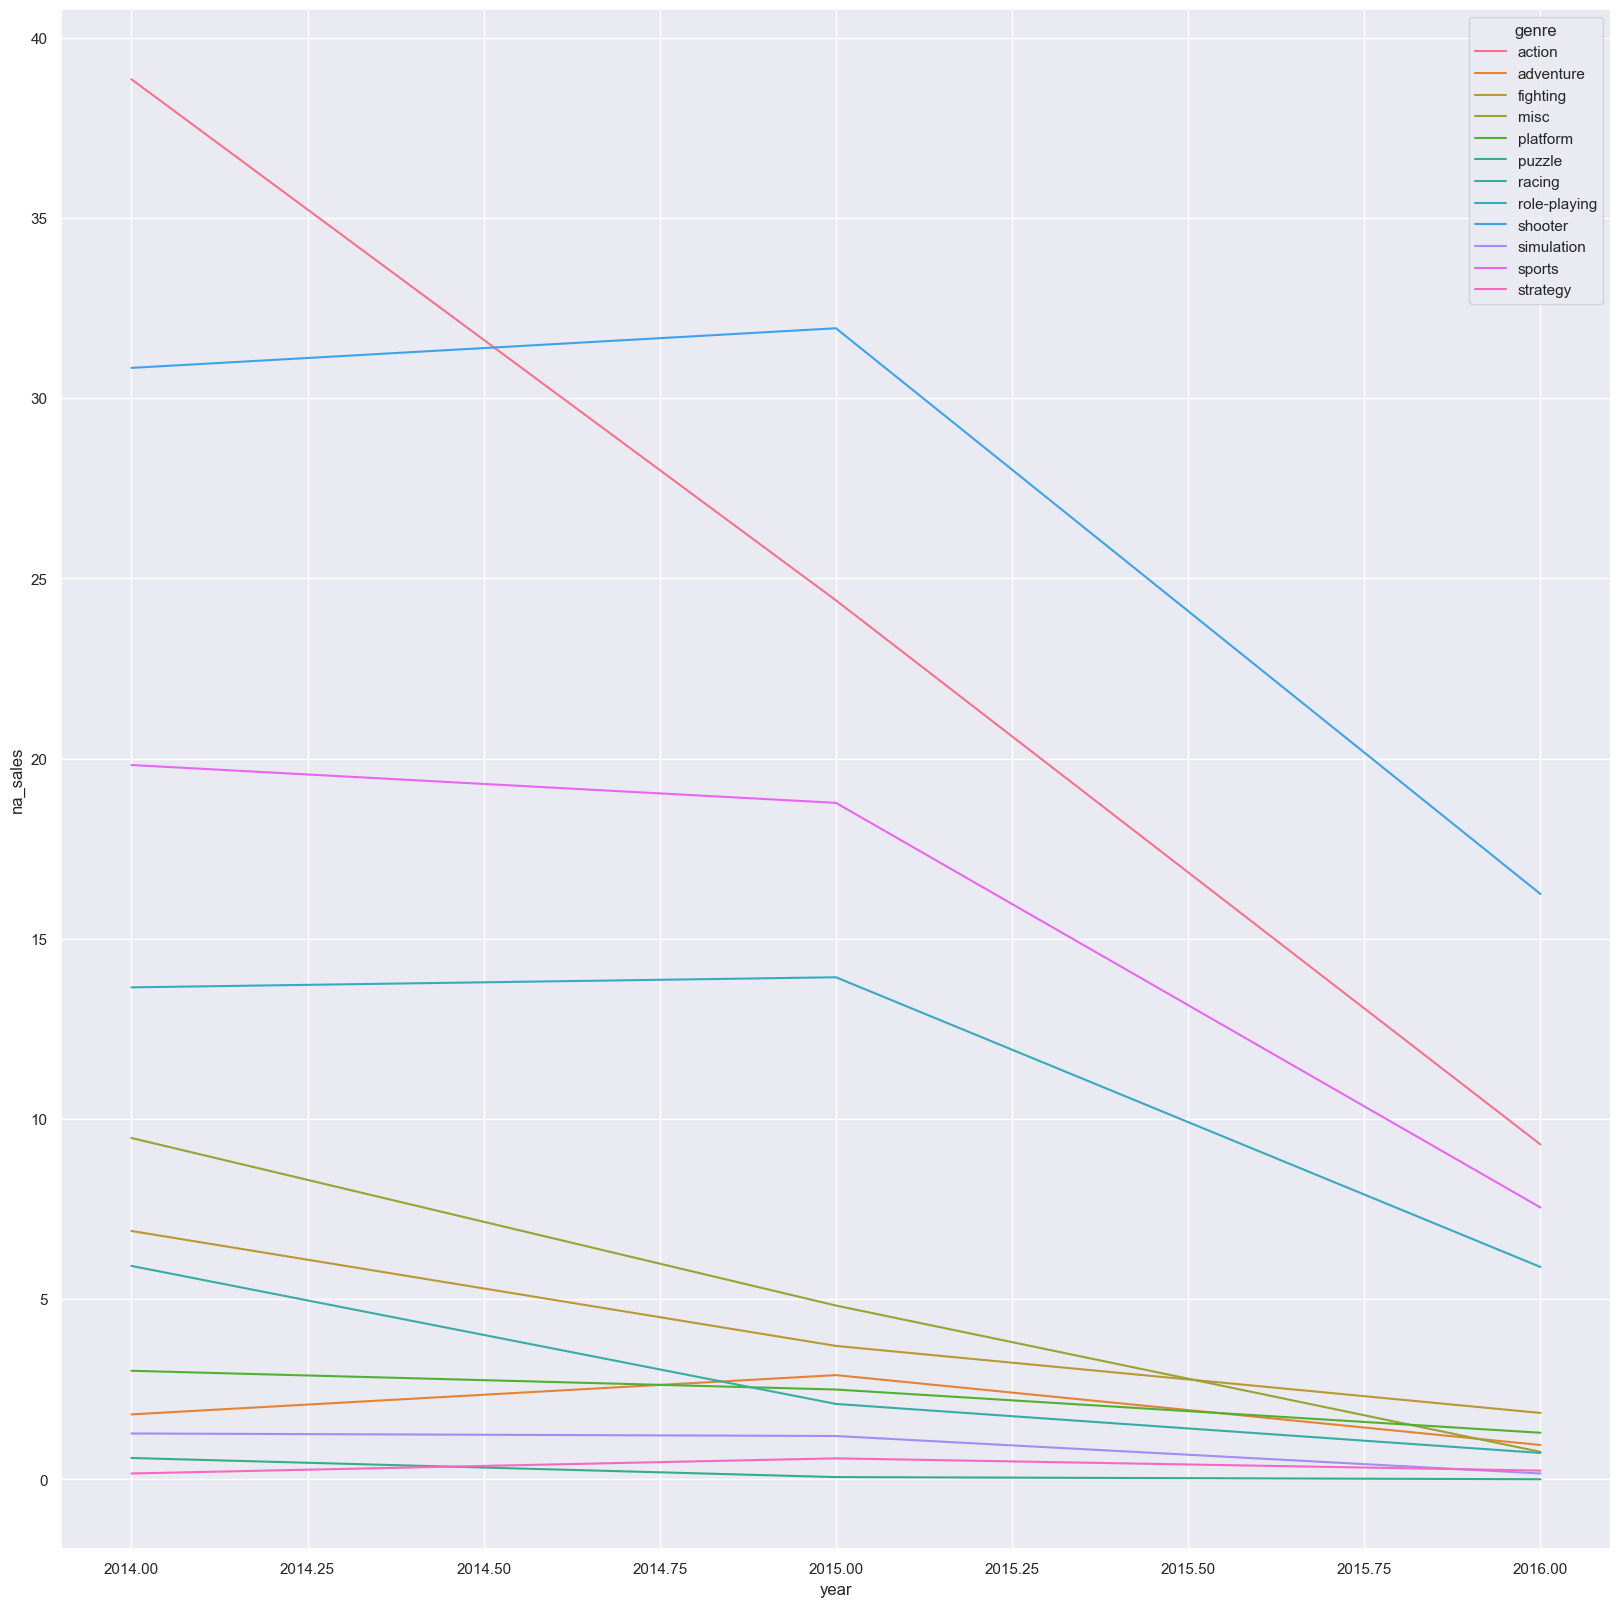

In [32]:
sns.set(rc={'figure.figsize':(20,20)})
sns.lineplot(data=reg_genre_sales, x='year', y='na_sales', hue='genre')

<AxesSubplot:xlabel='year', ylabel='eu_sales'>

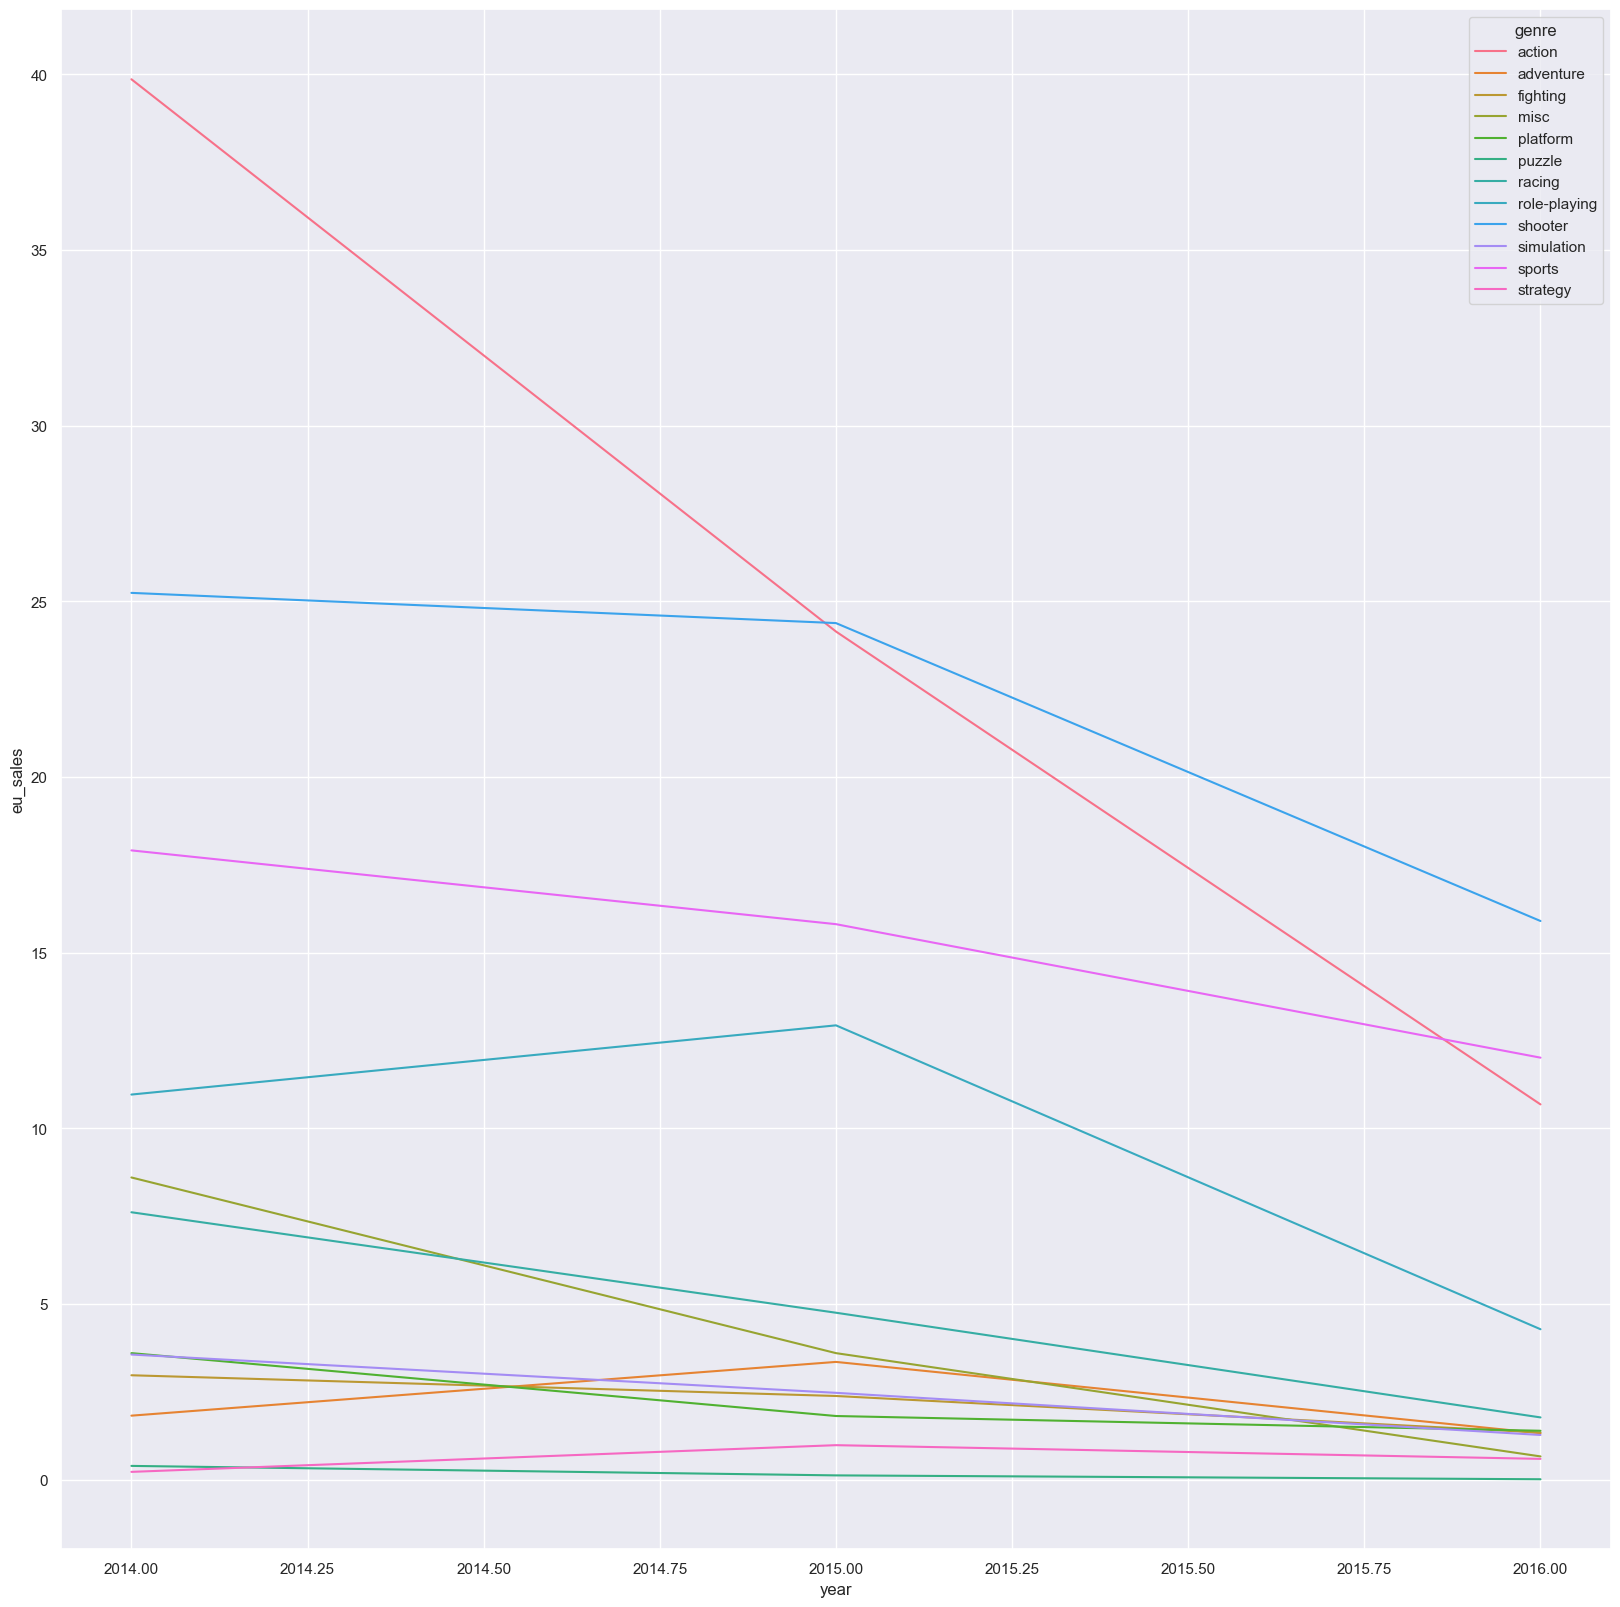

In [33]:
sns.set(rc={'figure.figsize':(20,20)})
sns.lineplot(data=reg_genre_sales, x='year', y='eu_sales', hue='genre')

<AxesSubplot:xlabel='year', ylabel='jp_sales'>

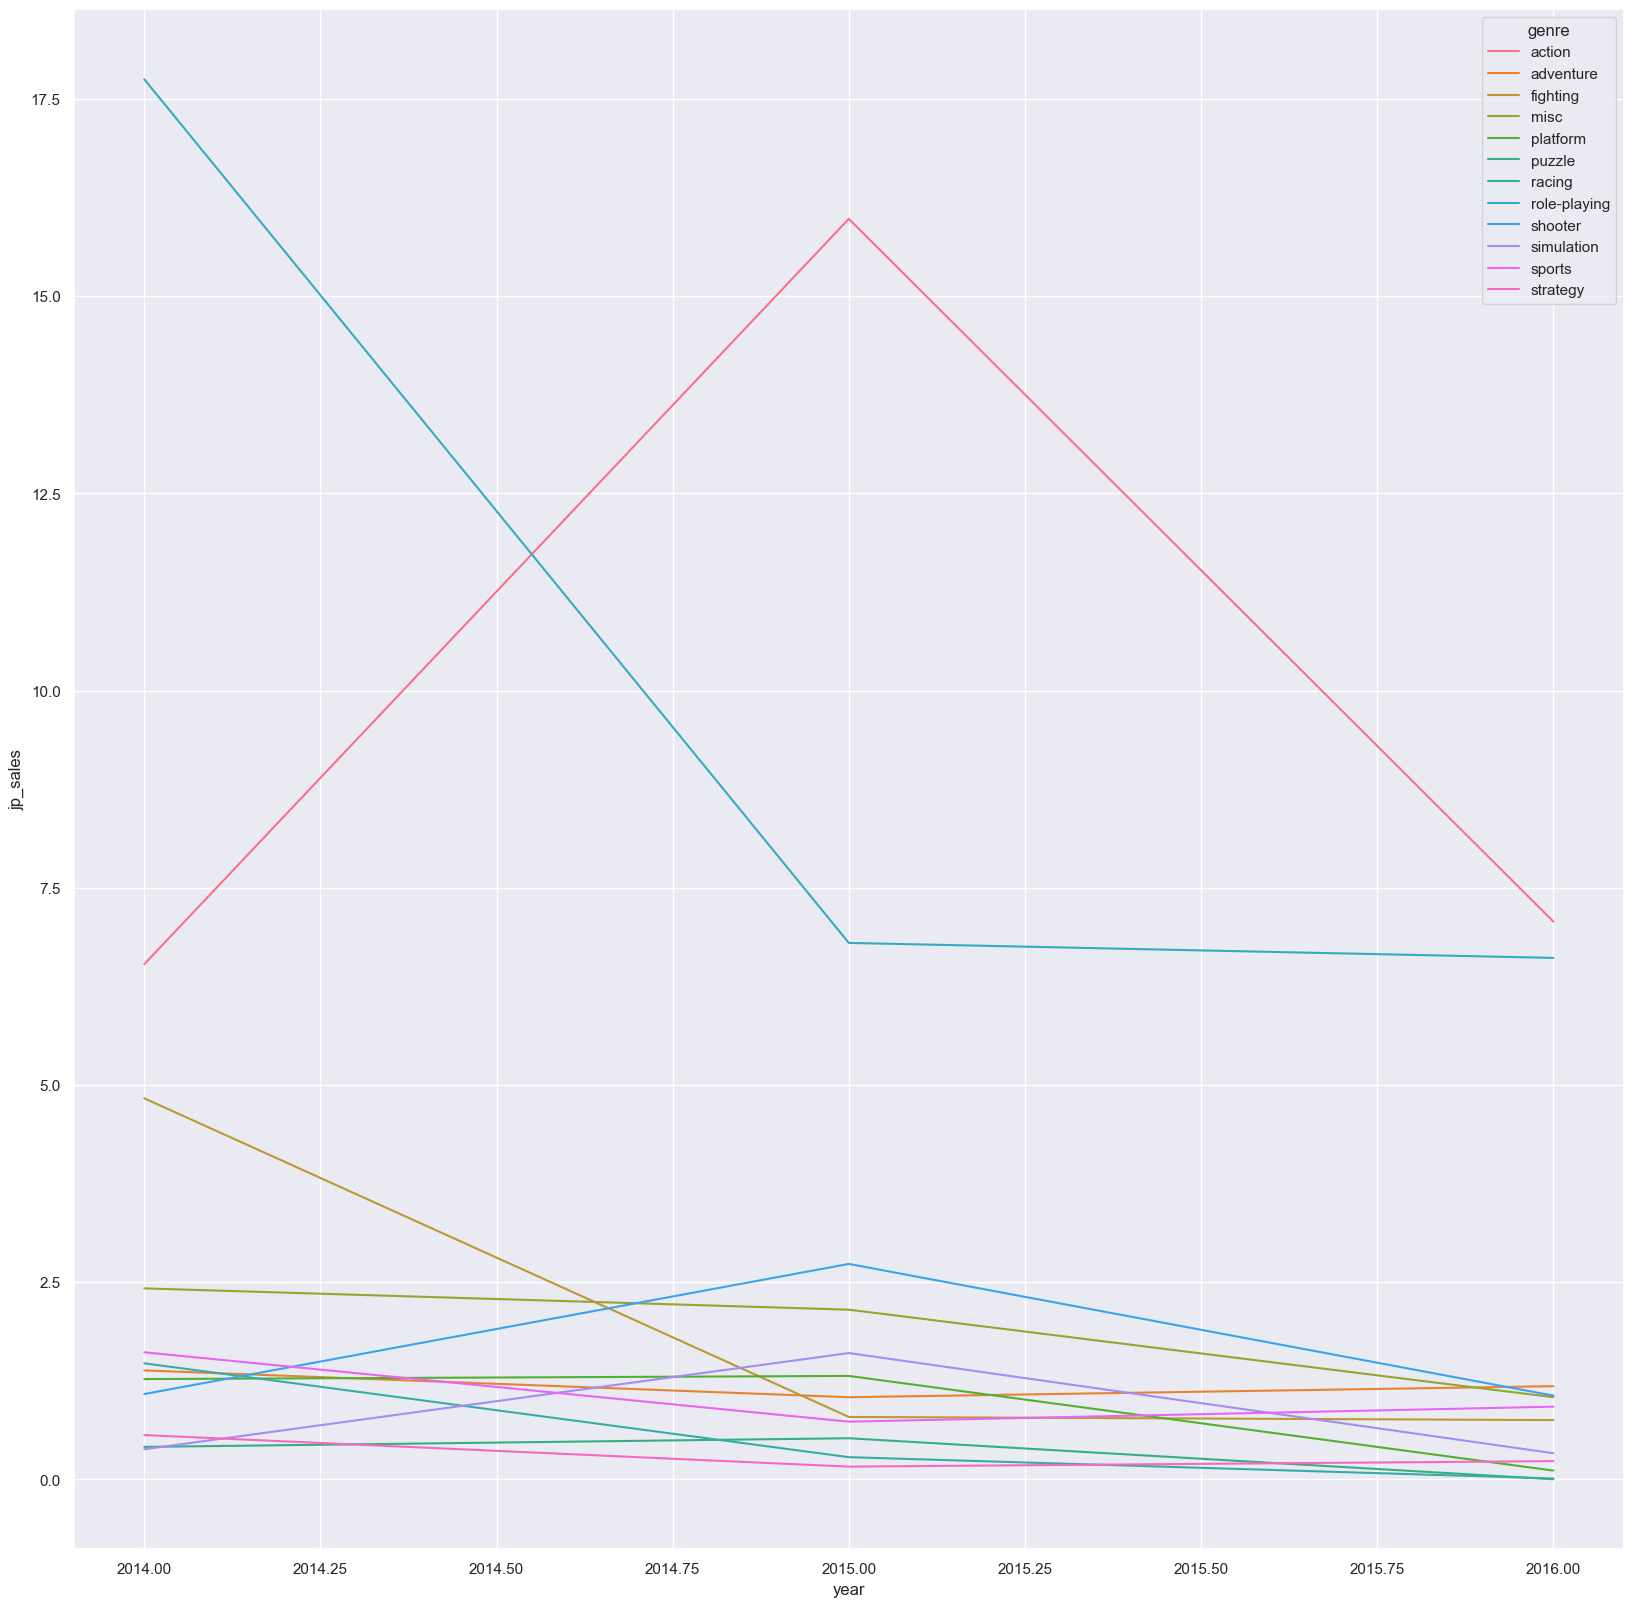

In [34]:
sns.set(rc={'figure.figsize':(20,20)})
sns.lineplot(data=reg_genre_sales, x='year', y='jp_sales', hue='genre')

#### Вывод

Наиболее насыщенными являются рынки США и европейский, японский же заметно отличается от них - на нем есть только два популярных жанра: action и role-playing, а жанры shooter и sports, которые показывают высокие продажи на западном рынке, в Японии имеют меньший успех.
Если же выделять топ-5 жанров для каждого региона, то:
* для США:
    * shooter
    * action 
    * sports
    * role-playing
    * racing
* для Европы:
    * shooter
    * sports
    * action
    * role-play
    * racing
* для Японии:
    * action
    * role-playing
    * shooter
    * misc
    * adventure

#### Популярные платформы

In [35]:
reg_platform = recent[['year', 'platform', 'na_sales', 'eu_sales', 'jp_sales']]
reg_platform_sales = pd.pivot_table(reg_platform, index = ['platform', 'year'], values = ['na_sales', 'eu_sales', 'jp_sales'], aggfunc = 'sum')
display(reg_platform_sales)

eu_sales  jp_sales  na_sales
platform year                              
3ds      2014      8.73     20.69     12.33
         2015      5.06     15.52      6.17
         2016      2.33      8.03      4.14
pc       2014      8.87      0.00      3.51
         2015      5.57      0.00      2.36
         2016      3.53      0.00      1.36
ps3      2014     18.24      6.25     16.39
         2015      6.04      3.67      4.99
         2016      1.26      1.30      0.67
ps4      2014     46.50      2.97     34.75
         2015     51.76      6.31     42.37
         2016     31.78      5.74     21.49
psp      2014      0.00      0.24      0.00
         2015      0.00      0.12      0.00
psv      2014      2.45      6.13      1.98
         2015      0.69      4.85      0.39
         2016      0.39      3.56      0.15
wii      2014      1.86      0.00      1.59
         2015      0.62      0.00      0.43
         2016      0.11      0.00      0.06
wiiu     2014      6.66      3.19     10.50
         2015      5.01      3.45      6.76
         2016      1.48      0.67      2.10
x360     2014     11.28      0.08     20.25
         2015      3.50      0.00      7.36
         2016      0.71      0.00      0.69
xone     2014     18.15      0.14     30.97
         2015     18.47      0.17     36.03
         2016      9.63      0.01     14.27

<AxesSubplot:xlabel='year', ylabel='na_sales'>

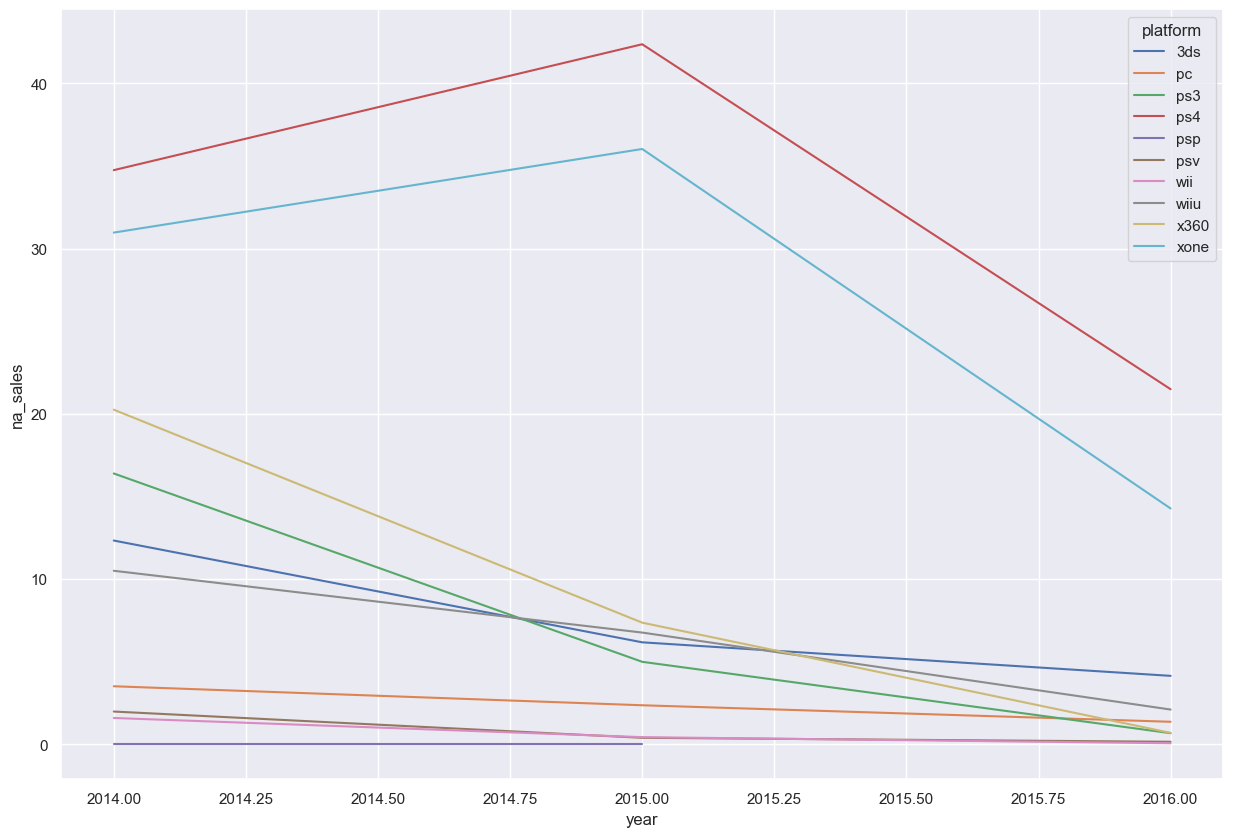

In [36]:
sns.set(rc={'figure.figsize':(15,10)})
sns.lineplot(data=reg_platform_sales, x='year', y='na_sales', hue='platform')

<AxesSubplot:xlabel='year', ylabel='eu_sales'>

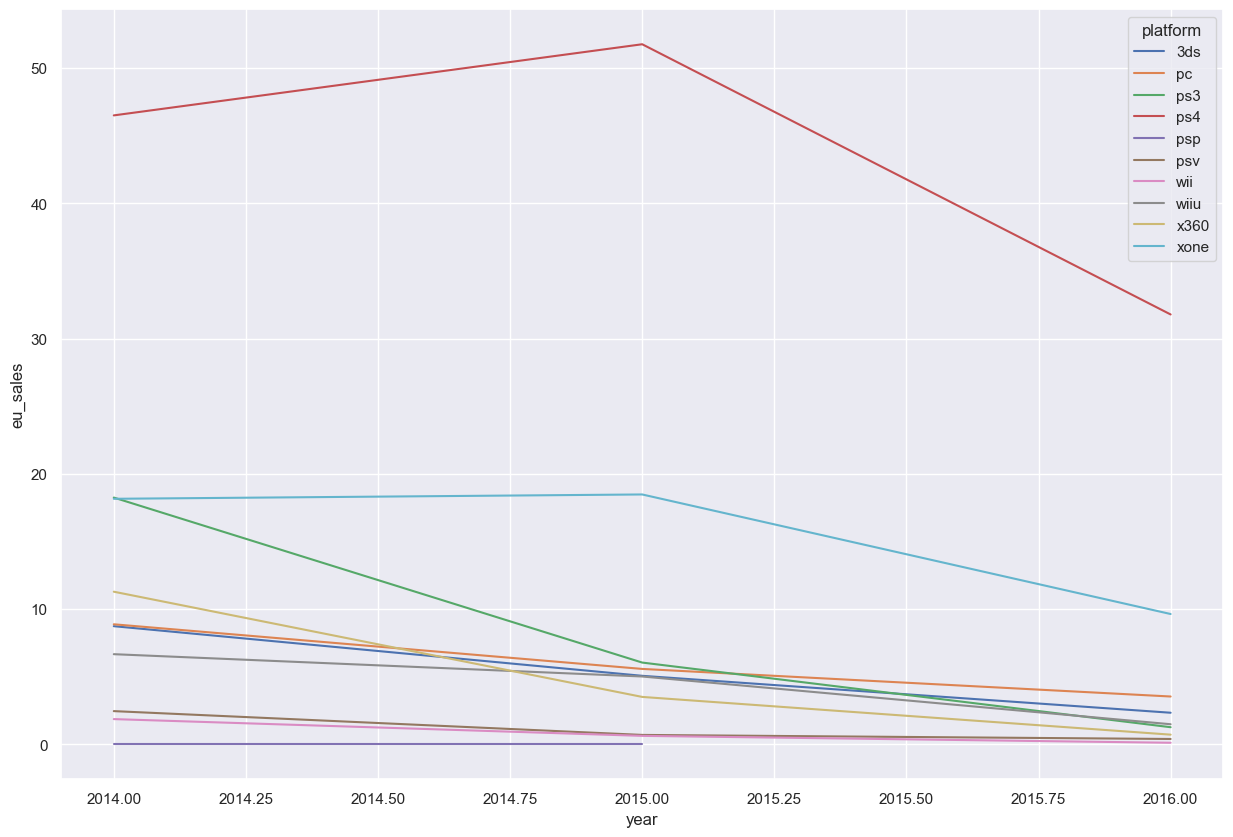

In [37]:
sns.set(rc={'figure.figsize':(15,10)})
sns.lineplot(data=reg_platform_sales, x='year', y='eu_sales', hue='platform')

<AxesSubplot:xlabel='year', ylabel='jp_sales'>

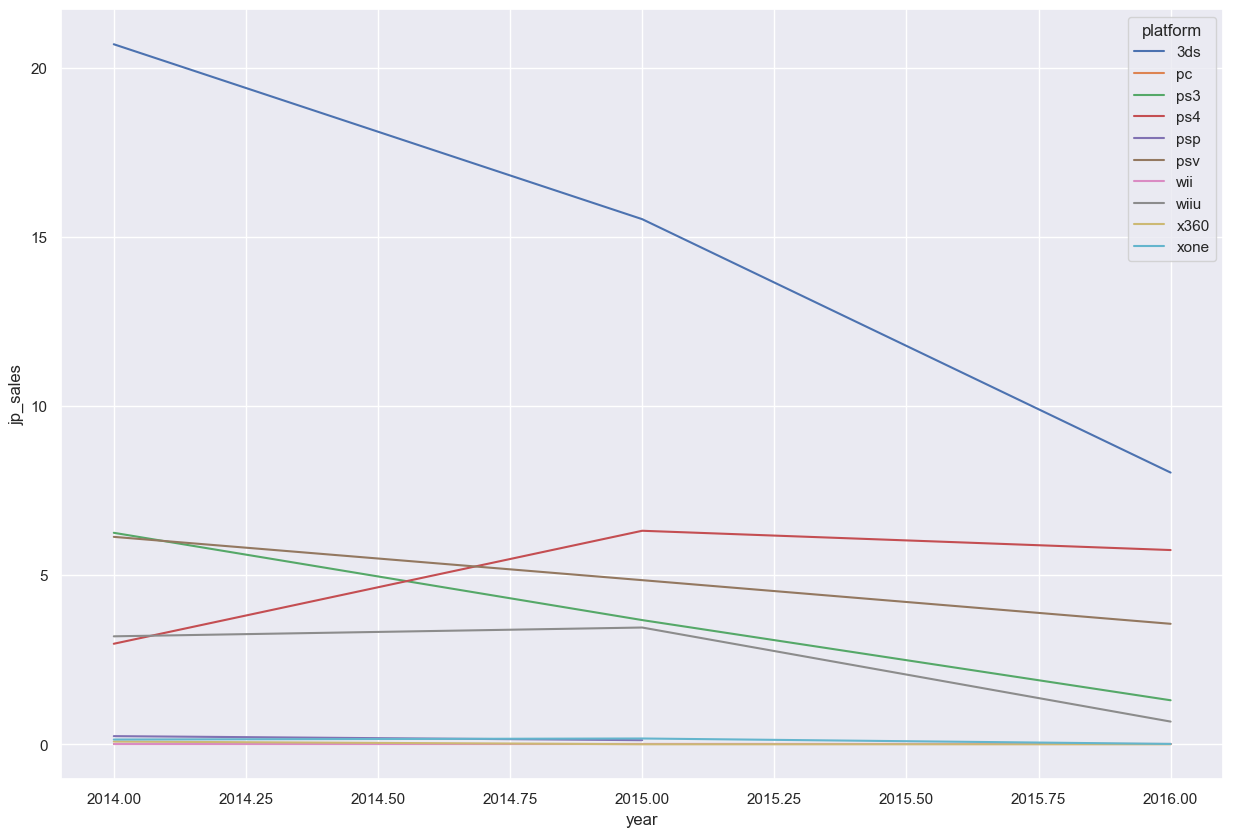

In [38]:
sns.set(rc={'figure.figsize':(15,10)})
sns.lineplot(data=reg_platform_sales, x='year', y='jp_sales', hue='platform')

#### Вывод

Как видно из графиков и сводных таблиц, в США и Европе лидером является PlayStation4. Японский же рынок, как и в случае с популярными жанрами, сильно отличается от западных рынков - здесь лидирует Nintendo 3DS.
Так будет выглядеть топ-5 платформ для каждого региона:
* США:
    * ps4
    * xone 
    * 3ds
    * wiiu
    * pc
* Европа:
    * ps4
    * xone
    * pc
    * 3ds
    * ps3
* Япония:
    * 3ds
    * ps4
    * psv
    * ps3
    * wiiu

Как можно заметить, на японском рынке лидируют японские же платформы (Nintendo, PlayStation).

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>
    
Не хватает выполнения задания
    
    Влияет ли рейтинг ESRB на продажи в отдельном регионе?
    

In [39]:
reg_esrb = recent[['year', 'platform', 'na_sales', 'eu_sales', 'jp_sales', 'rating']]
reg_esrb = reg_esrb.copy().query('rating != "none"')

<AxesSubplot:xlabel='year', ylabel='na_sales'>

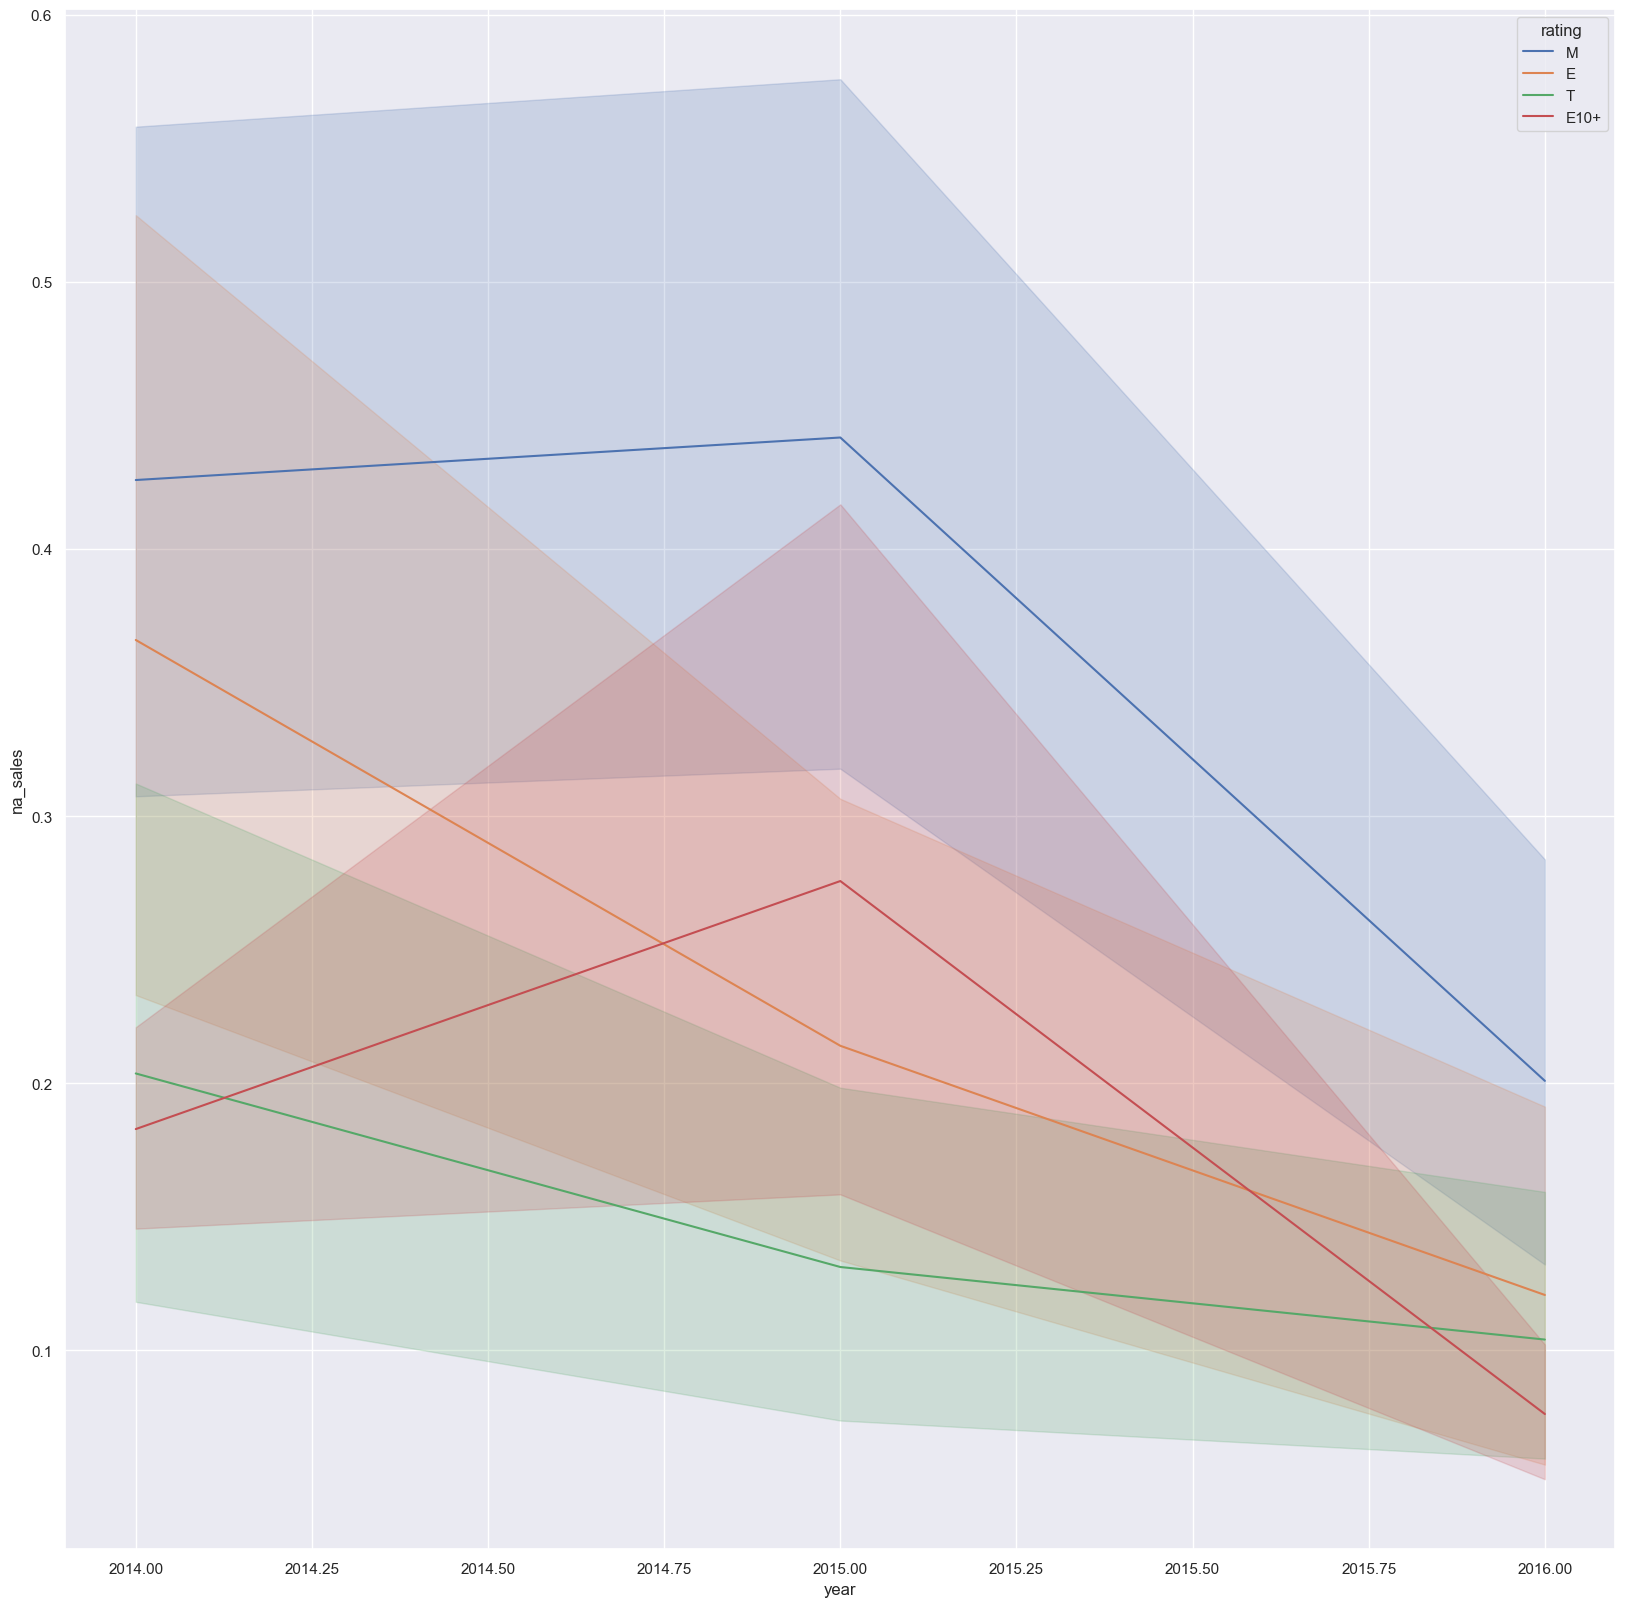

In [40]:
sns.set(rc={'figure.figsize':(20,20)})
sns.lineplot(data=reg_esrb, x='year', y='na_sales', hue='rating')

<AxesSubplot:xlabel='year', ylabel='eu_sales'>

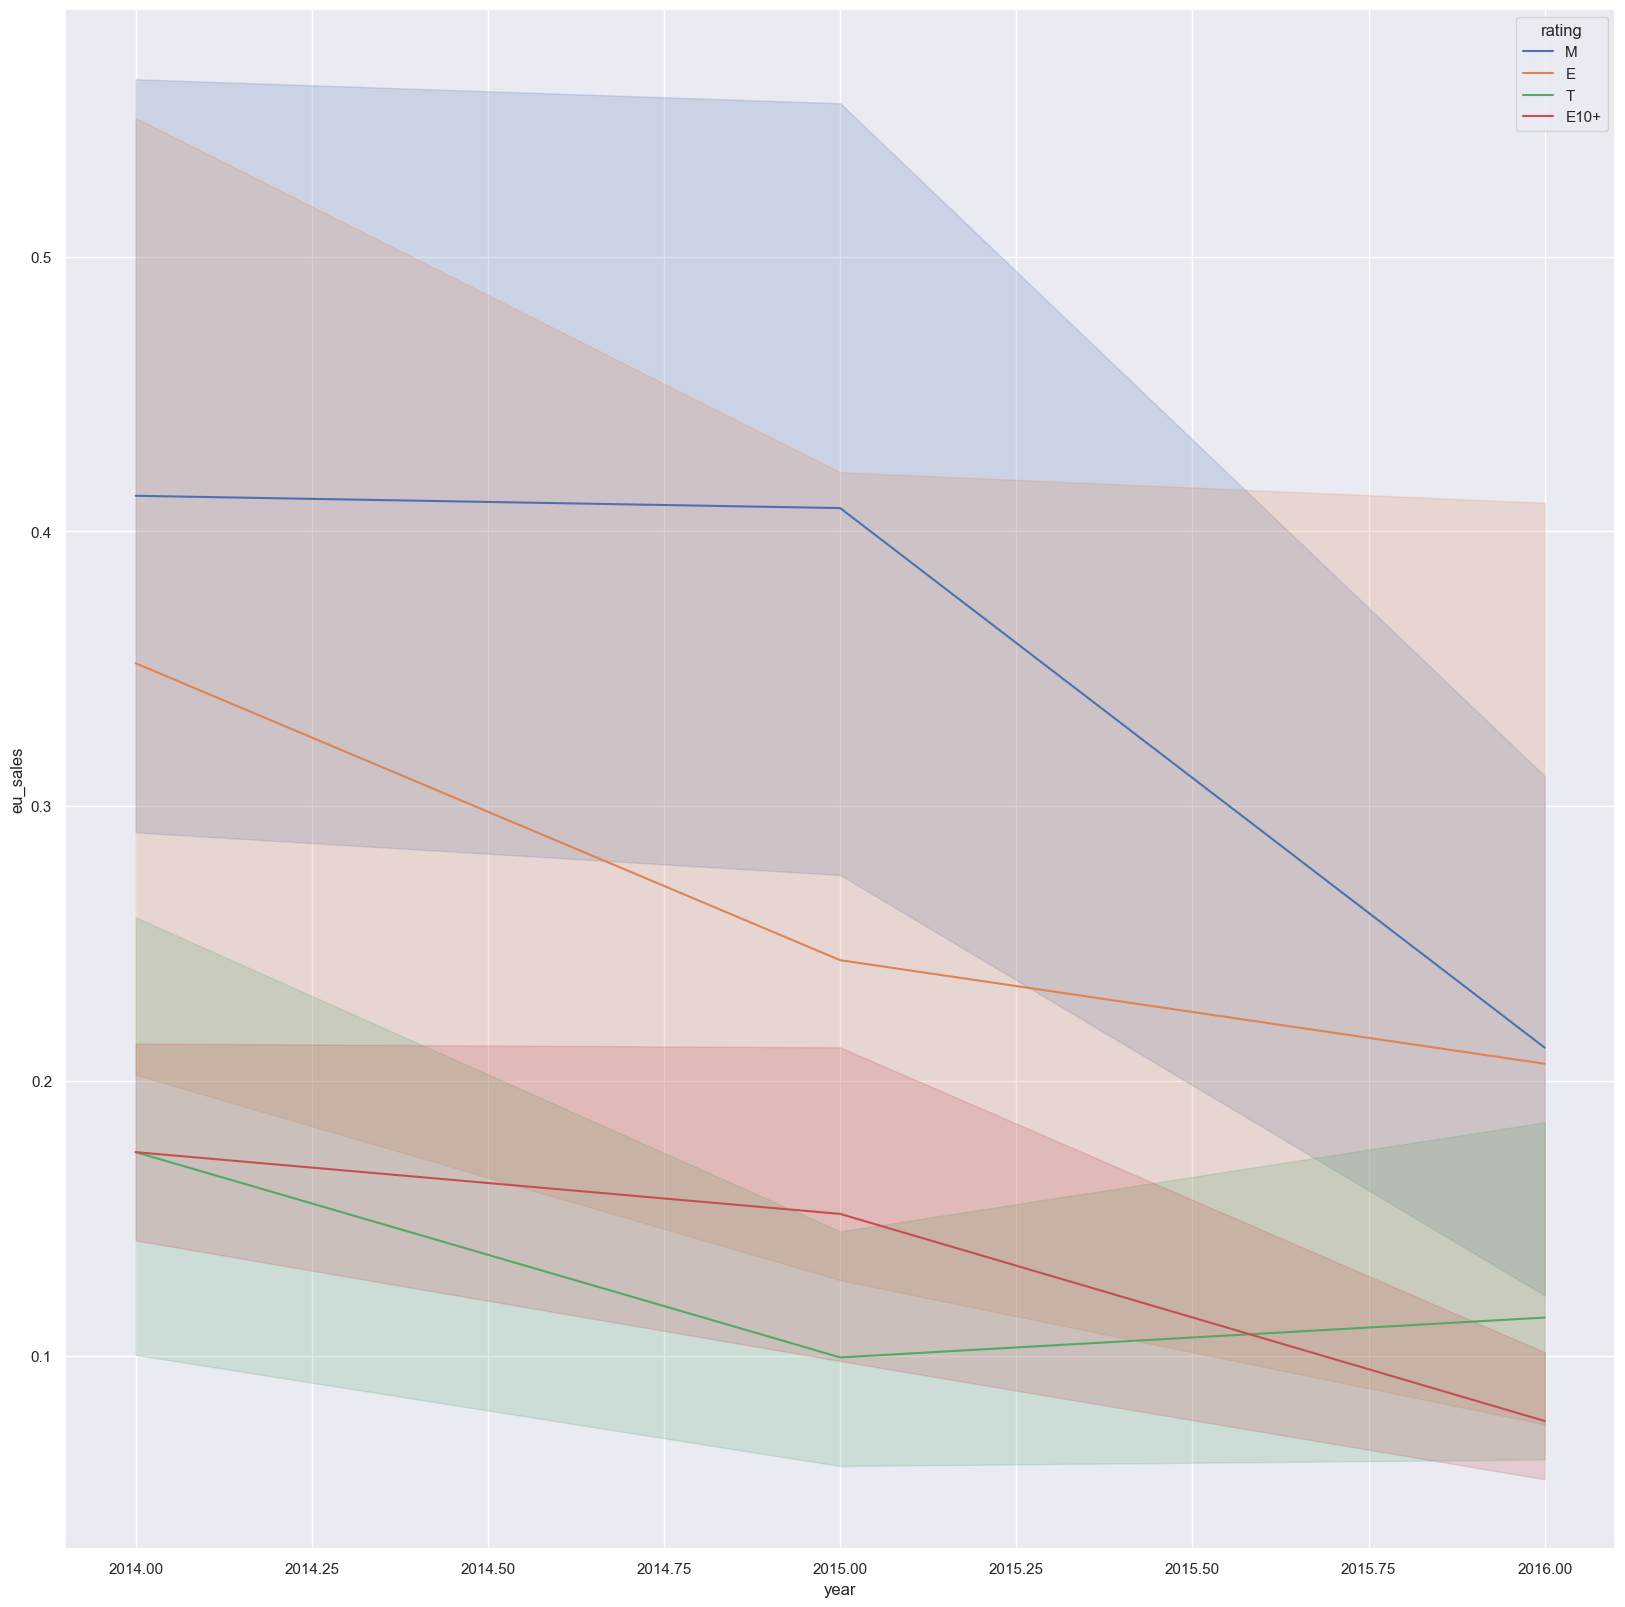

In [41]:
sns.set(rc={'figure.figsize':(20,20)})
sns.lineplot(data=reg_esrb, x='year', y='eu_sales', hue='rating')

<AxesSubplot:xlabel='year', ylabel='jp_sales'>

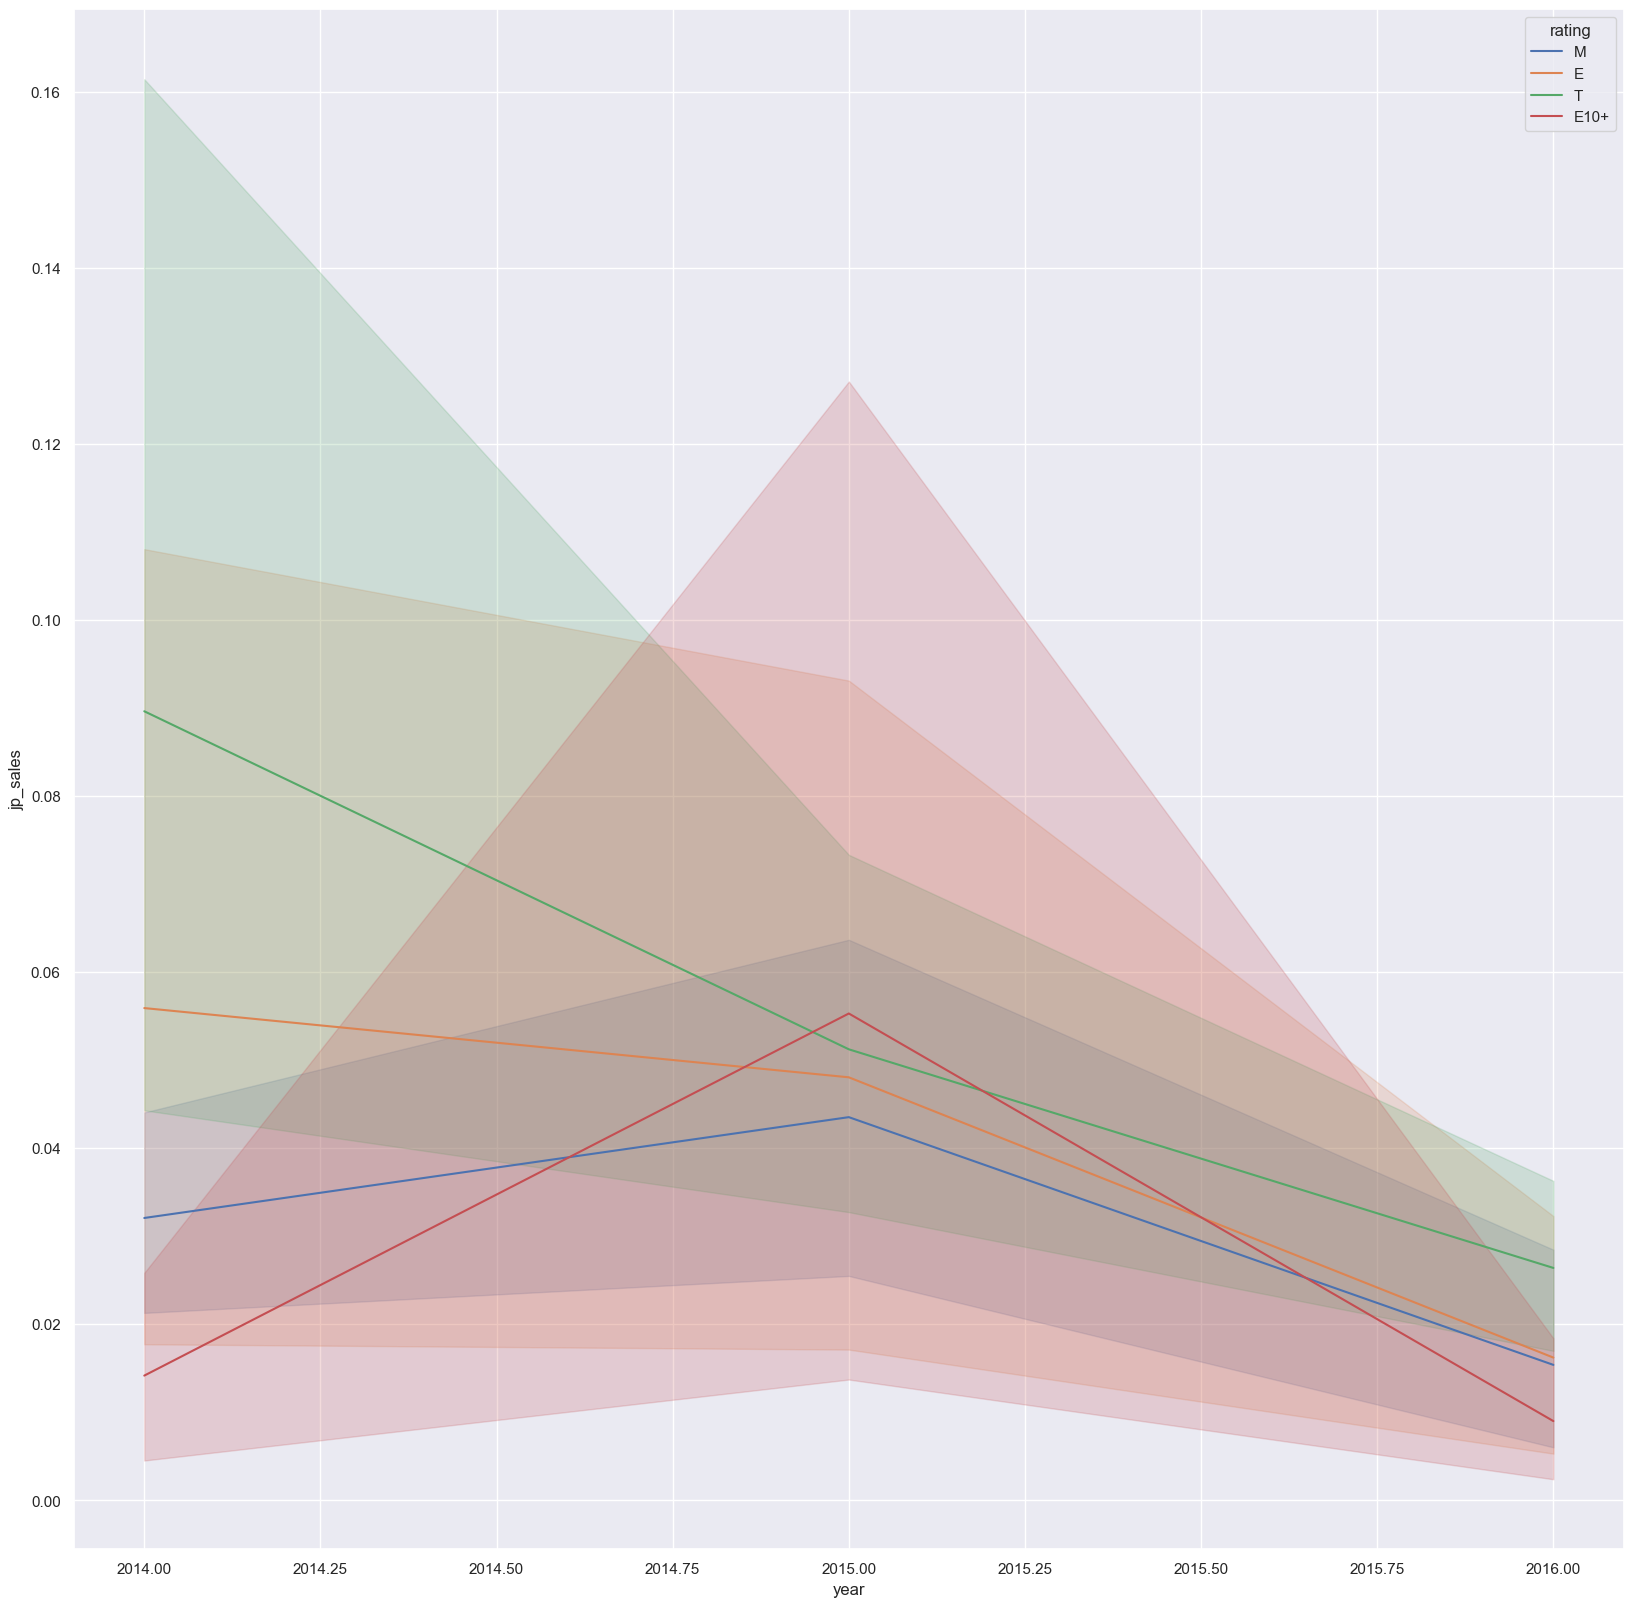

In [42]:
sns.set(rc={'figure.figsize':(20,20)})
sns.lineplot(data=reg_esrb, x='year', y='jp_sales', hue='rating')

#### Вывод

Как мы видим, на Западе ситуация такова - можно сказать, что наиболее высокие продажи у игр с рейтингом М (mature), следом идут игры с рейтингом Е, третье место делят Е10+ и Т. В Японии ситуация обстои

<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера 2<a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>
    
А как в японии так и не узнаем:) Нужно дописать, все же)
    
А еще, при твоем способе подсчета игры без рейтинга оказываются полностью исключенными из анализа. Но продажи именно этих игр могут указать на ключевое различие в регионах.

### Проверка гипотез

#### Первая нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
    
В задании еще просили объяснить Какой критерий применили для проверки гипотез и почему.

Посмотрим на данные о XBox One и ПК за актуальный период:

In [43]:
xone = recent.query('platform == "xone"')
pc = recent.query('platform == "pc"')
display(xone, pc, xone.info(), pc.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 99 to 16403
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             228 non-null    object        
 1   platform         228 non-null    object        
 2   year_of_release  228 non-null    datetime64[ns]
 3   genre            228 non-null    object        
 4   na_sales         228 non-null    float64       
 5   eu_sales         228 non-null    float64       
 6   jp_sales         228 non-null    float64       
 7   other_sales      228 non-null    float64       
 8   critic_score     228 non-null    float64       
 9   user_score       228 non-null    float64       
 10  rating           228 non-null    object        
 11  year             228 non-null    int64         
 12  general_sales    228 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(4)
memory usage: 24.9+ KB
<class 'pandas.

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year,general_sales
99,call of duty: black ops 3,xone,2015-01-01,shooter,4.59,2.11,0.01,0.68,0.0,0.0,none,2015,7.39
165,grand theft auto v,xone,2014-01-01,action,2.81,2.19,0.00,0.47,97.0,7.9,M,2014,5.47
179,call of duty: advanced warfare,xone,2014-01-01,shooter,3.22,1.55,0.01,0.48,81.0,5.4,M,2014,5.26
241,halo 5: guardians,xone,2015-01-01,shooter,2.78,1.27,0.03,0.41,84.0,6.4,T,2015,4.49
269,fallout 4,xone,2015-01-01,role-playing,2.51,1.32,0.01,0.38,88.0,6.2,M,2015,4.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16361,sébastien loeb rally evo,xone,2016-01-01,racing,0.00,0.01,0.00,0.00,63.0,8.2,E,2016,0.01
16374,rugby challenge 3,xone,2016-01-01,sports,0.00,0.01,0.00,0.00,0.0,6.6,E,2016,0.01
16376,zombiu,xone,2016-01-01,action,0.00,0.01,0.00,0.00,0.0,0.0,none,2016,0.01
16391,prison architect,xone,2016-01-01,action,0.01,0.00,0.00,0.00,74.0,6.7,none,2016,0.01


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year,general_sales
455,the sims 4,pc,2014-01-01,simulation,1.00,1.82,0.0,0.23,70.0,3.9,T,2014,3.05
1516,fallout 4,pc,2015-01-01,role-playing,0.51,0.67,0.0,0.10,84.0,5.4,M,2015,1.28
1659,farming simulator 2015,pc,2014-01-01,simulation,0.08,1.04,0.0,0.07,0.0,0.0,none,2014,1.19
1711,grand theft auto v,pc,2015-01-01,action,0.39,0.69,0.0,0.09,96.0,7.9,M,2015,1.17
2274,the elder scrolls online,pc,2014-01-01,role-playing,0.32,0.51,0.0,0.07,71.0,5.7,M,2014,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16241,ride 2,pc,2016-01-01,racing,0.00,0.01,0.0,0.00,78.0,7.9,E,2016,0.01
16250,rugby world cup 2015,pc,2015-01-01,sports,0.00,0.01,0.0,0.00,0.0,1.4,E,2015,0.01
16348,codename: panzers complete collection,pc,2016-01-01,strategy,0.00,0.01,0.0,0.00,0.0,0.0,none,2016,0.01
16362,the amazing spider-man 2 (2014),pc,2014-01-01,action,0.00,0.01,0.0,0.00,0.0,0.0,none,2014,0.01


None

None

In [44]:
display(xone['user_score'].mean(), pc['user_score'].mean())

4.772368421052631

5.088741721854304

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Здорово, что проверяешь данные и выводишь средние:)

In [45]:
alpha = .05

results = st.ttest_ind(
    xone['user_score'], 
    pc['user_score'],
    equal_var = False, nan_policy='omit'
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.3198109245979811
Не получилось отвергнуть нулевую гипотезу


#### Вывод

Судя по результатам Т-теста, нельзя сказать, что пользовательские оценки игр на ПК и XBox One отличаются.

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
    
Все верно, но что бы вывод был более точен и проффесионален, можно его поменять на такой:
    
    Исходя из теста у нас нет оснований утверждать, что средние пользовательские рейтинги платформ Xbox One и PC значимо различаются.


#### Вотрая нулевая гипотеза: средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковы

Тем же способом проверим игры жанров Action и Sports:

In [46]:
action = recent.query('genre == "action"')
sports = recent.query('genre == "sports"')
display(action, sports, action.info(), sports.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619 entries, 42 to 16441
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             619 non-null    object        
 1   platform         619 non-null    object        
 2   year_of_release  619 non-null    datetime64[ns]
 3   genre            619 non-null    object        
 4   na_sales         619 non-null    float64       
 5   eu_sales         619 non-null    float64       
 6   jp_sales         619 non-null    float64       
 7   other_sales      619 non-null    float64       
 8   critic_score     619 non-null    float64       
 9   user_score       619 non-null    float64       
 10  rating           619 non-null    object        
 11  year             619 non-null    int64         
 12  general_sales    619 non-null    float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(4)
memory usage: 67.7+ KB
<class 'pandas.

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year,general_sales
42,grand theft auto v,ps4,2014-01-01,action,3.96,6.31,0.38,1.97,97.0,8.3,M,2014,12.62
165,grand theft auto v,xone,2014-01-01,action,2.81,2.19,0.00,0.47,97.0,7.9,M,2014,5.47
224,the last of us,ps4,2014-01-01,action,1.88,2.00,0.07,0.77,0.0,0.0,none,2014,4.72
230,uncharted: the nathan drake collection,ps4,2015-01-01,action,2.07,1.71,0.08,0.76,86.0,8.1,T,2015,4.62
294,watch dogs,ps4,2014-01-01,action,1.40,1.90,0.11,0.64,80.0,6.3,M,2014,4.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16411,kyoukai no shirayuki,psv,2016-01-01,action,0.00,0.00,0.01,0.00,0.0,0.0,none,2016,0.01
16422,dynasty warriors: eiketsuden,ps3,2016-01-01,action,0.00,0.00,0.01,0.00,0.0,0.0,none,2016,0.01
16423,metal gear solid v: ground zeroes,pc,2014-01-01,action,0.00,0.01,0.00,0.00,80.0,7.6,M,2014,0.01
16430,the longest 5 minutes,psv,2016-01-01,action,0.00,0.00,0.01,0.00,0.0,0.0,none,2016,0.01


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year,general_sales
77,fifa 16,ps4,2015-01-01,sports,1.12,6.12,0.06,1.28,82.0,4.3,E,2015,8.58
94,fifa 17,ps4,2016-01-01,sports,0.66,5.75,0.08,1.11,85.0,5.0,E,2016,7.60
143,fifa 15,ps4,2014-01-01,sports,0.80,4.33,0.05,0.90,82.0,5.7,E,2014,6.08
263,fifa 15,ps3,2014-01-01,sports,0.58,3.02,0.04,0.64,0.0,4.5,E,2014,4.28
313,nba 2k16,ps4,2015-01-01,sports,2.49,0.66,0.03,0.69,87.0,6.7,E10+,2015,3.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15982,nhl 16,ps3,2015-01-01,sports,0.00,0.01,0.00,0.00,0.0,0.0,none,2015,0.01
16162,r.b.i. baseball 2016,ps4,2016-01-01,sports,0.01,0.00,0.00,0.00,0.0,0.0,none,2016,0.01
16250,rugby world cup 2015,pc,2015-01-01,sports,0.00,0.01,0.00,0.00,0.0,1.4,E,2015,0.01
16369,tour de france 2014,ps3,2014-01-01,sports,0.00,0.01,0.00,0.00,0.0,0.0,E,2014,0.01


None

None

In [47]:
display(action['user_score'].mean(), sports['user_score'].mean())

3.2437802907915994

4.121739130434783

In [48]:
alpha = .05

results = st.ttest_ind(
    action['user_score'], 
    sports['user_score'],
    equal_var = False, nan_policy='omit'
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0006646333120910831
Отвергаем нулевую гипотезу


#### Вывод

В случае с различными жанрами, однако, можно сказать, что пользовательские оценки действительно различаются - и, судя по средним оценкам, Sports имеет более высокие пользовательские оценки.

### Вывод

* Первым делом были обработаны и структурированы данные для дальнейшей работы - заполнены или удалены пропуски, сменены типы данных
* В ходе исследования прибыльности в ретроспективе всех данных лет:
    * мы увидели, что лидером является ps2, затем идут x360 и ps3, а после - wii, ds, ps
    * пик игровой индустрии, судя по графику, пришелся на 2008-2009 годы, а наибольшее количество игр было выпущено примерно в период с 2005 по 2011 год
    * средняя продолжительность активной жизни той или иной платформы - примерно пять лет, при этом пик ее популярности находится в центре этого промежутка времени; наибольший всплеск активности платформ наблюдается в период с 2007 по 2013, затем наступает резкий спад
* Поскольку нам было необходимо сделать прогноз для 2017 года, мы взяли отрезок времени в 2-3 года, т.е. с 2014 по текущий, 2016:
    * у playstation4 и xone наблюдается пик, приходящийся на 2015 год, затем идет спад (у 3ds этот спад начинается с 2014 года). Наиболее популярной на данный период остается playstation4, а xone и 3ds переживают не лучшие времена
    * в случае с playstation4 отзывы критиков влияют на продажи чуть больше, чем отзывы пользователей (корреляция 0,21 и 0,1 соответственно), также, можно заметить и отрицательный рост продаж на протяжении выбранного периода времени, и, соответственно, количества отзывов как критиков, так и пользователей. Интересна также и сильная взяимосвязь между оценками пользователей и критиков - вероятно, оценки у тех и других получают в общей сложности одни и те же игры
    * в целом, ситуация с Xbox One похожа на предыдущую, однако, тут корреляция между оценками критиков и продажами несколько больше (0,27 против 0,21) и меньше зависимость между отзывами критиков и пользователей (0,79 против 0,9)
    * у Nintendo DS 3 наблюдается самая слабая корреляция между оценками и продажами (по 0,05 и для пользователей, и для критиков), но, также, и самая слабая отрицательная корреляция между годами и продажами, что может говорить о том, что продажи игр на этой платформе наиболее стабильны, и не испытывают столь сильного спада, как в двух остальных случаях
    * среди жанров с высокими продажами находятся action, shooter, sports и role-playing - между ними и остальными жанрами наблюдается значительный разрыв прибыльности. Наименее популярны игры жанров puzzle, strategy и simulation
* Что касается пользователей разных регионов, можно отметить следующие тенденции:
    * Наиболее насыщенными являются рынки США и европейский, японский же заметно отличается от них - на нем есть только два популярных жанра: action и role-playing, а жанры shooter и sports, которые показывают высокие продажи на западном рынке, в Японии имеют меньший успех. Если же выделять топ-5 жанров для каждого региона, то:

    * для США:
        * shooter
        * action
        * sports
        * role-playing
        * racing
    * для Европы:
        * shooter
        * sports
        * action
        * role-play
        * racing
    * для Японии:
        * action
        * role-playing
        * shooter
        * misc
        * adventure
    * Как видно из графиков и сводных таблиц, в США и Европе лидером является PlayStation4. Японский же рынок, как и в случае с популярными жанрами, сильно отличается от западных рынков - здесь лидирует Nintendo 3DS. Так будет выглядеть топ-5 платформ для каждого региона (как можно заметить, на японском рынке лидируют японские же платформы (Nintendo, PlayStation)):

    * США:
        * ps4
        * xone
        * 3ds
        * wiiu
        * pc
    * Европа:
        * ps4
        * xone
        * pc
        * 3ds
        * ps3
    * Япония:
        * 3ds
        * ps4
        * psv
        * ps3
        * wiiu
* Первую нулевую гипотезу - средние пользовательские рейтинги платформ Xbox One и PC одинаковые, - по результатам Т-теста не получилось опровергнуть
* Такого, однако, нельзя сказать о второй нулевой гипотезе - средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковы, - средние оценки жанра Sports оказались выше

В итоге, посмотрев на имеющиеся у нас данные, можно сказать следующее - популарность той или иной игры во многом зависит от региона: западный и восточный рынок значительно различаются. На Западе доминируют последние модели приставок как от playstation, так и от Xbox, на Востоке же рынок держат японские приставки от playstation и Nintendo. Различаются и популярные жанры - на Западе это прежде всего shooter, action и sports, а для Японии - action, role-playing и shooter. В целом, если мы делаем прогноз для западного рынка, то имеет смысл сделать ставки на игры для популярных платформ последнего поколения (playstation, Xbox), жанров shooter, action и sports (высокие оценки критиков и пользователей будут плюсом). 